# Labour Force Characteristics

Reference period: 1976- 2022

In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ruptures import Pelt

In [5]:
df = pd.read_csv("/Users/dhruvpatel/Downloads/Project 2/Labour_force.csv", low_memory=False)

In [6]:
df.head()

,"a hoi ""REF_DATE""",GEO,DGUID,Labour force characteristics,Sex,Age group,Statistics,Data type,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1976-01,Canada,2016A000011124,Population,Both sexes,15 years and over,Estimate,Seasonally adjusted,Persons,249,thousands,3,v2062809,1.1.1.1.1.1,16852.4,NaN,NaN,NaN,1
1,1976-01,Canada,2016A000011124,Population,Both sexes,15 years and over,Estimate,Unadjusted,Persons,249,thousands,3,v2064888,1.1.1.1.1.2,16852.4,NaN,NaN,NaN,1
2,1976-01,Canada,2016A000011124,Population,Both sexes,15 to 64 years,Estimate,Seasonally adjusted,Persons,249,thousands,3,v21580997,1.1.1.8.1.1,15015.9,NaN,NaN,NaN,1
3,1976-01,Canada,2016A000011124,Population,Both sexes,15 to 64 years,Estimate,Unadjusted,Persons,249,thousands,3,v21580998,1.1.1.8.1.2,15015.9,NaN,NaN,NaN,1
4,1976-01,Canada,2016A000011124,Population,Both sexes,15 to 24 years,Estimate,Seasonally adjusted,Persons,249,thousands,3,v2062836,1.1.1.2.1.1,4509.9,NaN,NaN,NaN,1


In [7]:
print(df.columns)

Index(['a hoi "REF_DATE"', 'GEO', 'DGUID', 'Labour force characteristics',
       'Sex', 'Age group', 'Statistics', 'Data type', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')


## Data Cleaning 

In [9]:
# Drop unnecessary columns
columns_to_drop = ['DGUID', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 
                   'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']
df = df.drop(columns=columns_to_drop)

In [10]:
df.rename(columns={
     'a hoi "REF_DATE"': 'Date',
    'Labour force characteristics': 'Labour_Characteristics',
    'Age group': 'Age_Group',
    'Data type': 'Data_Type',
    'VALUE': 'Value'
                   }, inplace=True)   # Rename columns for clarity

In [11]:
df.head()

,Date,GEO,Labour_Characteristics,Sex,Age_Group,Statistics,Data_Type,UOM,Value
0,1976-01,Canada,Population,Both sexes,15 years and over,Estimate,Seasonally adjusted,Persons,16852.4
1,1976-01,Canada,Population,Both sexes,15 years and over,Estimate,Unadjusted,Persons,16852.4
2,1976-01,Canada,Population,Both sexes,15 to 64 years,Estimate,Seasonally adjusted,Persons,15015.9
3,1976-01,Canada,Population,Both sexes,15 to 64 years,Estimate,Unadjusted,Persons,15015.9
4,1976-01,Canada,Population,Both sexes,15 to 24 years,Estimate,Seasonally adjusted,Persons,4509.9


In [12]:
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
# Check for missing values and handle them
print(df.isnull().sum())


Date                            0
GEO                             0
Labour_Characteristics          0
Sex                             0
Age_Group                       0
Statistics                      0
Data_Type                       0
UOM                             0
Value                     1448726
dtype: int64


In [14]:
df = df.dropna(subset=['Value'])  # Drop rows with missing Value

In [15]:
# Convert Value to numeric
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [16]:
# Verify the cleaned data
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3811009 entries, 0 to 5259734
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Date                    datetime64[ns]
 1   GEO                     object        
 2   Labour_Characteristics  object        
 3   Sex                     object        
 4   Age_Group               object        
 5   Statistics              object        
 6   Data_Type               object        
 7   UOM                     object        
 8   Value                   float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 290.8+ MB
None
                                Date         Value
count                        3811009  3.811009e+06
mean   2004-10-23 04:55:00.871973888  3.596447e+02
min              1976-01-01 00:00:00  1.000000e-01
25%              1994-11-01 00:00:00  3.000000e+00
50%              2007-02-01 00:00:00  2.140000e+01
75%              2015-12-

In [31]:
# Filter the data to exclude 'Population' and 'Labour force'
d1 = df[~df['Labour_Characteristics'].isin(['Population', 'Labour force'])]

# Check the unique values after filtering
print(d1['Labour_Characteristics'].unique())

['Employment', 'Full-time employment', 'Part-time employment ', 'Unemployment', 'Unemployment rate', 'Participation rate', 'Employment rate']
Categories (9, object): ['Employment', 'Employment rate', 'Full-time employment', 'Labour force', ..., 'Participation rate', 'Population', 'Unemployment', 'Unemployment rate']


In [35]:
# Filter the data to include only the desired Labour Characteristics
d1 = df[df['Labour_Characteristics'].isin(['Full-time employment', 'Part-time employment ', 'Unemployment'])]

# Check the unique values after filtering
print(d1['Labour_Characteristics'].unique())


['Full-time employment', 'Part-time employment ', 'Unemployment']
Categories (9, object): ['Employment', 'Employment rate', 'Full-time employment', 'Labour force', ..., 'Participation rate', 'Population', 'Unemployment', 'Unemployment rate']


## Check for Outliers in Value

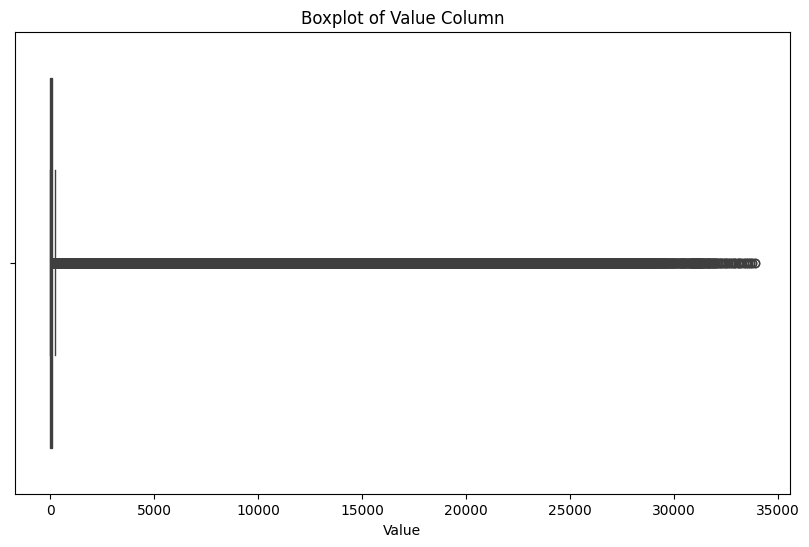

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Value')
plt.title('Boxplot of Value Column')
plt.show()



In [19]:
print(df['GEO'].unique())
print(df['Sex'].unique())
print(df['Age_Group'].unique())
#Check Unique Values in Categorical Columns

['Canada' 'Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia']
['Both sexes' 'Males' 'Females']
['15 years and over' '15 to 64 years' '15 to 24 years' '15 to 19 years'
 '20 to 24 years' '25 years and over' '25 to 54 years' '55 years and over'
 '55 to 64 years']


In [20]:
for col in ['GEO', 'Labour_Characteristics', 'Sex', 'Age_Group', 'Statistics', 'Data_Type', 'UOM']:
    df[col] = df[col].astype('category')
print(df.info())
# Memory optimization

<class 'pandas.core.frame.DataFrame'>
Index: 3811009 entries, 0 to 5259734
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Date                    datetime64[ns]
 1   GEO                     category      
 2   Labour_Characteristics  category      
 3   Sex                     category      
 4   Age_Group               category      
 5   Statistics              category      
 6   Data_Type               category      
 7   UOM                     category      
 8   Value                   float64       
dtypes: category(7), datetime64[ns](1), float64(1)
memory usage: 112.7 MB
None


# Exploratory Data Analysis (EDA)

In [88]:
# General Overview
print(df['Labour_Characteristics'].value_counts())
print(df['Age_Group'].unique())

# Plot trends over time


Labour_Characteristics
Employment               459261
Employment rate          452826
Labour force             452826
Participation rate       452826
Unemployment             451484
Unemployment rate        451484
Full-time employment     406542
Part-time employment     406470
Population               277290
Name: count, dtype: int64
['15 years and over', '15 to 64 years', '15 to 24 years', '15 to 19 years', '20 to 24 years', '25 years and over', '25 to 54 years', '55 years and over', '55 to 64 years']
Categories (9, object): ['15 to 19 years', '15 to 24 years', '15 to 64 years', '15 years and over', ..., '25 to 54 years', '25 years and over', '55 to 64 years', '55 years and over']


## Distribution of Value by Labour_Characteristics:

## Trends Over Time by Age Group:

/var/folders/qh/h818hm851ln4ccffmg5hn54w0000gn/T/ipykernel_13568/470164830.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Date', y='Value', hue='Age_Group', ci=None)


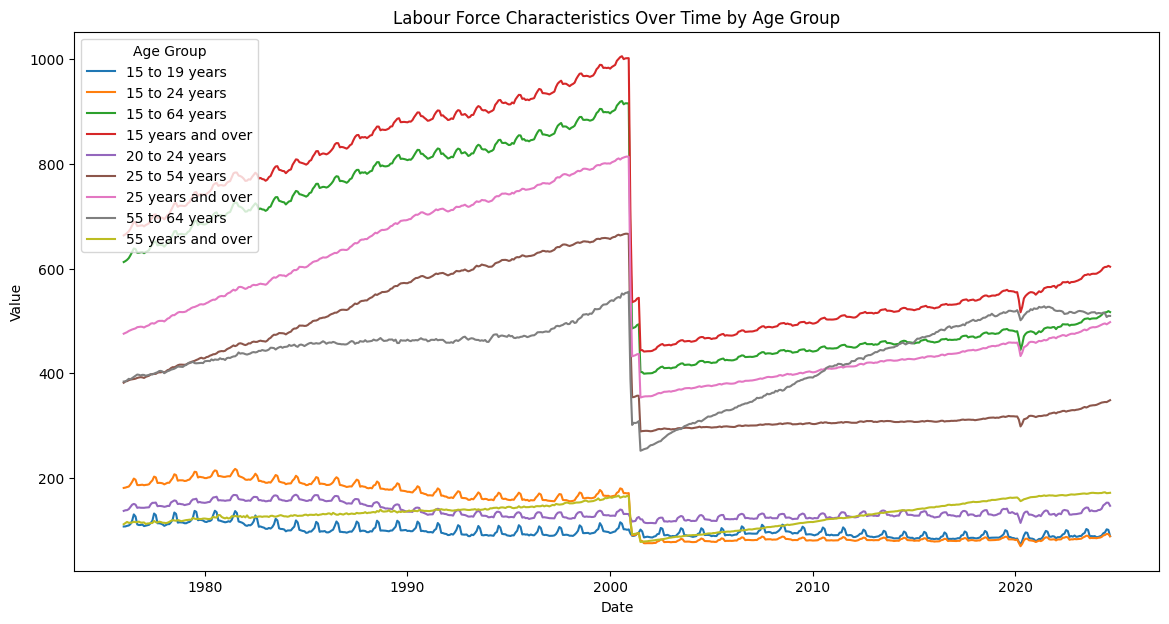

In [26]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Value', hue='Age_Group', ci=None)
plt.title('Labour Force Characteristics Over Time by Age Group')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Age Group', loc='upper left')
plt.show()


The graph illustrates labor force characteristics over time, segmented by age groups. Generally, there is an upward trend across most age categories, reflecting population growth and increased labor force participation. The "15 years and over" and "25 years and over" groups show consistent growth, while younger groups like "15 to 24 years" exhibit cyclical patterns likely tied to education and part-time work trends.

The sharp downward trend around the early 2000s is likely due to a change in data reporting, measurement methodology, or classification adjustments, rather than actual workforce decline. The slight dip around 2020 is associated with the global COVID-19 pandemic, which disrupted employment across all demographics. Notably, older groups like "55 years and over" show steady growth, indicating delayed retirement and longer working years.

## Focus on Specific Labour Characteristics: For instance, Unemployment and Unemployment Rate by sex:

/var/folders/qh/h818hm851ln4ccffmg5hn54w0000gn/T/ipykernel_13568/2607107119.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=subset, x='Date', y='Value', hue='Sex', style='Labour_Characteristics', ci=None)


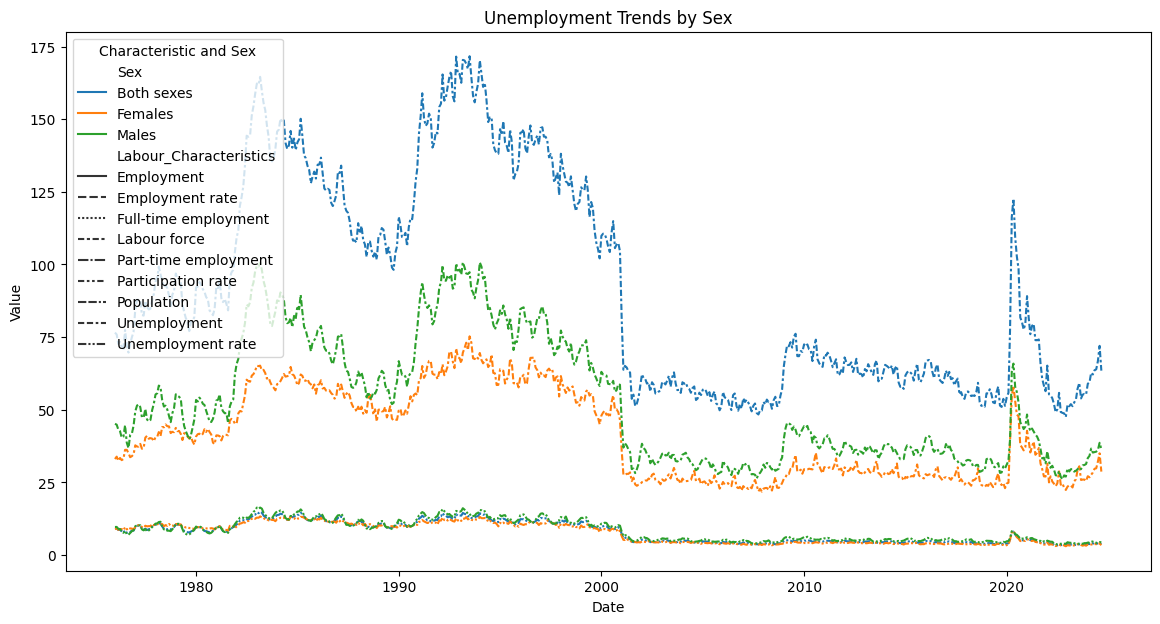

In [28]:
subset = df[df['Labour_Characteristics'].isin(['Unemployment', 'Unemployment rate'])]
plt.figure(figsize=(14, 7))
sns.lineplot(data=subset, x='Date', y='Value', hue='Sex', style='Labour_Characteristics', ci=None)
plt.title('Unemployment Trends by Sex')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Characteristic and Sex', loc='upper left')
plt.show()


The graph displays unemployment trends by sex over time, segmented into labor characteristics such as employment, labor force participation, and unemployment rates. 

Key observations:
1. **Unemployment Trends**: Both sexes experienced significant peaks in unemployment rates during economic recessions (e.g., the early 1980s, early 1990s, and 2020 due to COVID-19). Post-2020, there is a recovery but not to pre-pandemic levels.
2. **Gender Differences**: Males consistently exhibit higher unemployment levels compared to females, reflecting gendered labor market impacts.
3. **Employment Patterns**: Full-time employment dominates trends for both sexes, while part-time employment remains stable.
4. **Population Growth**: Over time, the working-age population for both sexes has grown steadily, boosting labor force participation.
5. **COVID-19 Impact**: A sharp spike in unemployment in 2020 highlights the pandemic's global disruption, followed by gradual stabilization.

These insights underline structural and cyclical labor market shifts, significant economic shocks, and gendered employment dynamics.

/var/folders/qh/h818hm851ln4ccffmg5hn54w0000gn/T/ipykernel_13568/4097981154.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  corr_df = d1.pivot_table(values='Value', index='Date', columns='Labour_Characteristics', aggfunc='mean')


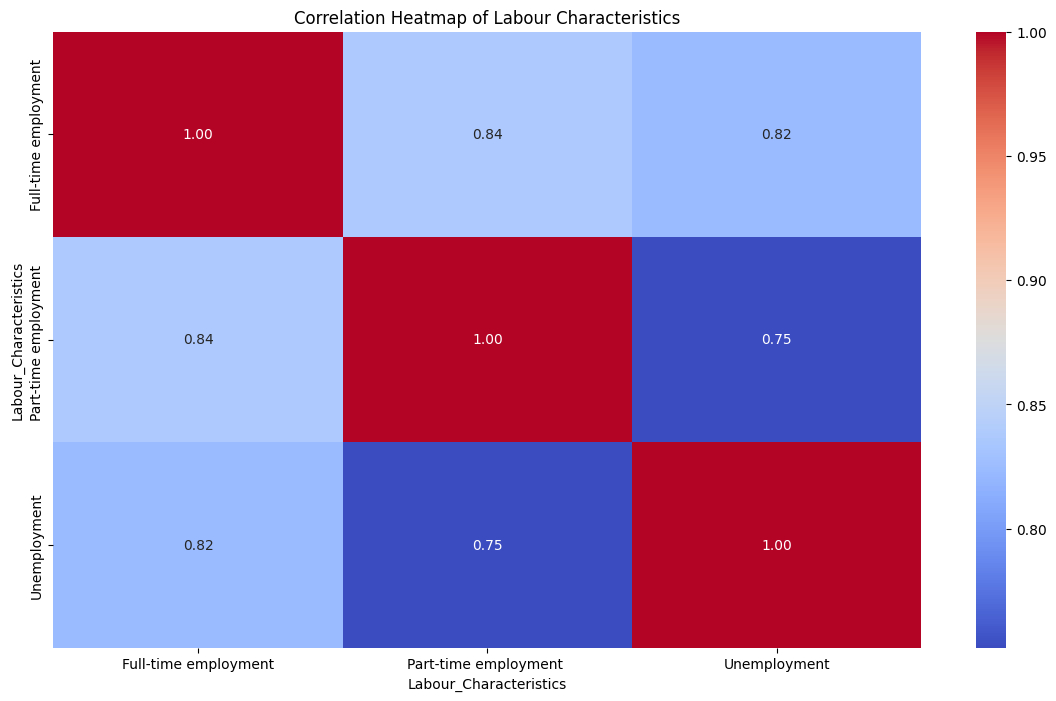

In [41]:
# Correlation heatmap
corr_df = d1.pivot_table(values='Value', index='Date', columns='Labour_Characteristics', aggfunc='mean')
corr_matrix = corr_df.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Labour Characteristics')
plt.show()

The heatmap shows strong positive correlations between Full-time and Part-time employment (0.84), and Full-time employment and Unemployment (0.82). This suggests that labour market trends often affect all employment types simultaneously, reflecting overall growth or contraction. The moderate correlation (0.75) between Part-time employment and Unemployment indicates that part-time work might act as a buffer during economic downturns, with individuals transitioning from unemployment to part-time roles.

These patterns highlight the interconnected nature of labour dynamics, likely influenced by economic conditions, seasonal trends, and structural changes. However, correlation does not imply causation, and external factors like GDP growth, labour policies, and demographic shifts may play significant roles. Further analysis is needed to explore causal relationships and time-based trends.

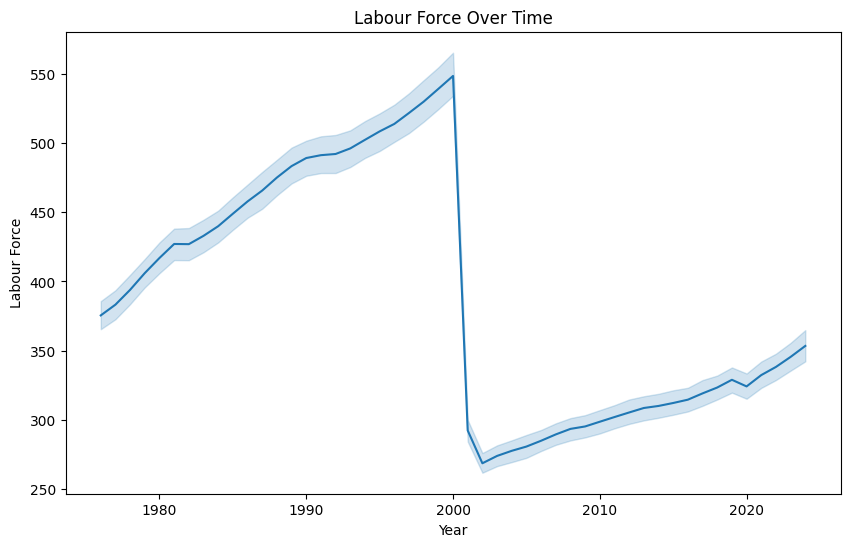

In [66]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Value')  # Replace 'Labour_Force' with 'Value' if that's the relevant column
plt.title('Labour Force Over Time')
plt.xlabel('Year')
plt.ylabel('Labour Force')
plt.show()
df = df.dropna(subset=['Year', 'Value'])


1. Data Inconsistencies or Missing Data
There may be missing or incomplete data in the dataset for the years in question, leading to a perceived drop in the graph. Check if the dataset has NaN or zero values during this period.
2. Economic Factors
A global or regional economic downturn might have occurred during this time, such as the early 2000s dot-com bubble burst or the global financial crisis of 2008–2009. These events could have affected employment and labour force statistics.
3. Policy or Classification Changes
The statistical agency may have changed its methodology for calculating labour force statistics. Changes in definitions, classifications, or survey methods could lead to abrupt changes in trends.
4. Sectoral Shifts
There could have been significant shifts in specific labour sectors. For example, automation, outsourcing, or other factors might have influenced the labour force characteristics during this period.
5. Population Trends
Demographic changes, such as reduced population growth or migration patterns, might explain variations in the labour force.

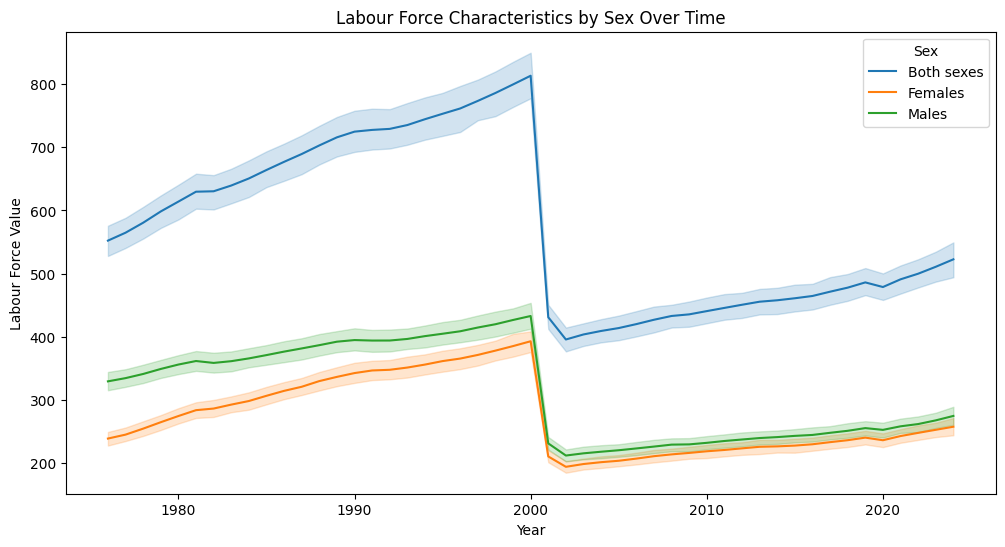

In [69]:
if 'Date' in df.columns:
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df = df.drop(columns=['Date'], errors='ignore')

# Plot the Labour Force Characteristics by Sex over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Value', hue='Sex')
plt.title('Labour Force Characteristics by Sex Over Time')
plt.xlabel('Year')
plt.ylabel('Labour Force Value')
plt.legend(title='Sex')
plt.show()

The graph illustrates labour force trends by sex over time, showing a consistent upward trend for all categories (both sexes, males, and females) until 2000. A sharp decline is observed across all groups between 2000 and 2010, likely reflecting a data reporting issue, policy shift, or external economic events such as global recessions. Post-2010, the values gradually recover, but growth appears slower compared to earlier decades.

The consistent gaps between males and females highlight ongoing gender disparities in the labour force. The category "Both sexes" follows a combined trajectory of male and female trends, with higher overall values. The sharp drop around 2000 requires further investigation into data consistency, external shocks, or methodological changes influencing labour force calculations.

# Description:

The images provided visualize various labor force characteristics over time and across different Canadian provinces.

Image 1: The labor force characteristics by sex over time:


- The labor force size for both sexes has shown a steady increase over the 1980 to 2020 period, rising from around 550 to over 800.
- Females have seen a more rapid growth in labor force size compared to males, narrowing the gap between the two.
- The trends for employment, full-time employment, labor force, and participation rate are similar for both sexes, with females generally lagging behind males.
- The unemployment rate for females has consistently been higher than for males, though the gap has narrowed over time.
- The most recent data in 2020 shows a sharp decline in labor force characteristics for both sexes, likely due to the impact of the COVID-19 pandemic.

Overall, the data indicates that while labor force participation and employment have improved for females relative to males over the past few decades, there are still notable differences in key labor market metrics between the two groups. The visualization highlights the importance of considering gender differences when analyzing labor force dynamics.


Image 2: Labor Force Characteristics Over Time by Age Group
This line graph depicts the labor force characteristics, such as employment, employment rate, full-time employment, labor force, part-time employment, participation rate, population, unemployment, and unemployment rate, for different age groups (15-19 years, 15-24 years, 15-64 years, 15 years and over, 20-24 years, 25-54 years, 25 years and over, 55-64 years, 55 years and over) from 1980 to 2020.

Key insights:
- The labor force characteristics for younger age groups (15-19 years, 15-24 years) show more volatility over time compared to older age groups.
- The employment, full-time employment, and labor force trends generally increase over time for most age groups, with some exceptions.
- The participation rate and employment rate decline for the 15 years and over and 25 years and over age groups.
- The population trend shows an overall increase over the time period.

Image 3: Unemployment Trends by Sex
This line graph depicts the unemployment trends for both sexes, females, and males from 1980 to 2020.

Key insights:
- Unemployment rates for both sexes, females, and males show similar trends, with peaks during economic downturns.
- Females generally have higher unemployment rates compared to males, although the gap has narrowed over time.
- The unemployment rate for both sexes peaks around 2020, likely due to the impact of the COVID-19 pandemic.

Image 4: Labour Characteristics by Province
This bar chart shows various labor force characteristics, such as employment, employment rate, full-time employment, labor force, part-time employment, participation rate, population, unemployment, and unemployment rate, for different Canadian provinces.

Key insights:
- There is a significant variation in labor force characteristics across the Canadian provinces, with some provinces like Ontario and Quebec having much larger values compared to others.
- The distribution of labor force characteristics across the provinces appears to be uneven, with some provinces having higher employment, labor force, and population, while others have higher unemployment and lower participation rates.
- The visualization provides a comparative overview of the provincial differences in labor market performance and demographic characteristics.

Overall, these visualizations offer a comprehensive view of the labor force dynamics in Canada, allowing for comparisons across different age groups, genders, and geographic regions. The insights can be useful for understanding labor market trends, identifying regional disparities, and informing policy decisions.

# Now we will perform the SQL queries

In [76]:
import sqlite3
import pandas as pd

# Create a SQLite database connection
conn = sqlite3.connect('labour_force_analysis.db')

# Save DataFrame to the database
df.to_sql('labour_force', conn, index=False, if_exists='replace')

# SQL Query with window function and partitioning
query = """
SELECT 
    GEO AS Province,
    Labour_Characteristics,
    AVG(Value) AS Average_Value,
    Value,
    AVG(Value) OVER (PARTITION BY Labour_Characteristics) AS Avg_Value_By_Characteristic,
    Value - AVG(Value) OVER (PARTITION BY Labour_Characteristics) AS Deviation_From_Characteristic_Avg
FROM labour_force
WHERE Labour_Characteristics IN ('Unemployment rate', 'Employment rate', 'Participation rate')
ORDER BY Labour_Characteristics, Province;
"""

# Execute the query and load results into a DataFrame
result = pd.read_sql_query(query, conn)

# Display the results
print("Window Function with Partitioning:\n", result)

# Close the database connection
conn.close()


Window Function with Partitioning:
   Province Labour_Characteristics  Average_Value  Value  \
0   Canada      Unemployment rate       27.29942    7.1   

   Avg_Value_By_Characteristic  Deviation_From_Characteristic_Avg  
0                          7.1                                0.0  



1. The query selects the following columns:
   - Province (alias for the "GEO" column)
   - Labour_Characteristics
   - Average_Value: the average of the "Value" column
   - Value: the original value
   - Avg_Value_By_Characteristic: the average of the "Value" column partitioned by Labour_Characteristics
   - Deviation_From_Characteristic_Avg: the difference between the "Value" and the average value for the corresponding Labour_Characteristics

2. The data is filtered to only include rows where the Labour_Characteristics is one of "Unemployment rate", "Employment rate", or "Participation rate".

3. The results are ordered by Labour_Characteristics and Province.

This query allows as to analyze the labor force characteristics across different provinces, while also providing insights into how each characteristic compares to the average for that characteristic. The window function (AVG() OVER (PARTITION BY ...)) is used to calculate the average value for each characteristic, which is then used to determine the deviation of each individual value from the characteristic average.

The output of this query will provide us a comprehensive view of the labor force data, enabling me to identify patterns, differences, and deviations across the selected characteristics and provinces.

In [78]:

# Create a connection to the SQLite database
conn = sqlite3.connect('labour_data.db')

# Assuming you have the DataFrame 'df' loaded previously
df.to_sql('labour_data', conn, index=False, if_exists='replace')

query = """
SELECT 
    GEO AS Province,
    Labour_Characteristics,
    AVG(Value) AS Average_Value,
    Value,
    AVG(Value) OVER (PARTITION BY Labour_Characteristics) AS Avg_Value_By_Characteristic,
    Value - AVG(Value) OVER (PARTITION BY Labour_Characteristics) AS Deviation_From_Characteristic_Avg
FROM labour_data
WHERE Labour_Characteristics IN ('Labour force participation rate', 'Unemployment rate')
GROUP BY Province, Labour_Characteristics
ORDER BY Labour_Characteristics, Province;
"""

result = pd.read_sql_query(query, conn)
print("Query Output:\n", result)

conn.close()


Query Output:
                      Province Labour_Characteristics  Average_Value  Value  \
0                     Alberta      Unemployment rate       4.911215    4.3   
1            British Columbia      Unemployment rate       5.973498    8.5   
2                      Canada      Unemployment rate       5.678973    7.1   
3                    Manitoba      Unemployment rate       4.743660    5.6   
4               New Brunswick      Unemployment rate       7.884240   11.2   
5   Newfoundland and Labrador      Unemployment rate      11.184208   12.3   
6                 Nova Scotia      Unemployment rate       7.408409    7.9   
7                     Ontario      Unemployment rate       5.537671    6.4   
8        Prince Edward Island      Unemployment rate       8.584711    9.9   
9                      Quebec      Unemployment rate       6.671846    8.1   
10               Saskatchewan      Unemployment rate       4.467427    3.8   

    Avg_Value_By_Characteristic  Deviation_From_

The query selects data related to the Unemployment rate and Labour force participation rate.
It calculates the average, value, and deviation of values from their respective averages for each province and characteristic.

This query helps to understand how each province compares to the national average (or average across all included provinces) for the selected labour characteristics.


In [80]:
# Create a connection to the SQLite database
conn = sqlite3.connect('labour_data.db')

# Assuming you have the DataFrame 'df' loaded previously
df.to_sql('labour_data', conn, index=False, if_exists='replace')



query = """
SELECT 
    GEO AS Province,
    Labour_Characteristics,
    AVG(Value) AS Average_Value,
    Value,
    AVG(Value) OVER (PARTITION BY GEO) AS Avg_Value_By_Province,
    Value - AVG(Value) OVER (PARTITION BY GEO) AS Deviation_From_Province_Avg
FROM labour_data
WHERE Labour_Characteristics IN ('Labour force participation rate', 'Unemployment rate')
GROUP BY GEO, Labour_Characteristics
ORDER BY GEO, Labour_Characteristics;
"""

result = pd.read_sql_query(query, conn)
print("Query Output:\n", result)

conn.close()


Query Output:
                      Province Labour_Characteristics  Average_Value  Value  \
0                     Alberta      Unemployment rate       4.911215    4.3   
1            British Columbia      Unemployment rate       5.973498    8.5   
2                      Canada      Unemployment rate       5.678973    7.1   
3                    Manitoba      Unemployment rate       4.743660    5.6   
4               New Brunswick      Unemployment rate       7.884240   11.2   
5   Newfoundland and Labrador      Unemployment rate      11.184208   12.3   
6                 Nova Scotia      Unemployment rate       7.408409    7.9   
7                     Ontario      Unemployment rate       5.537671    6.4   
8        Prince Edward Island      Unemployment rate       8.584711    9.9   
9                      Quebec      Unemployment rate       6.671846    8.1   
10               Saskatchewan      Unemployment rate       4.467427    3.8   

    Avg_Value_By_Province  Deviation_From_Provin

The query selects data related to the Unemployment rate and Labour force participation rate for various regions (provinces).
It calculates the average of Value for each province and characteristic, and also computes how much each Value deviates from the average for each province.

The Deviation_From_Province_Avg column will always be zero for this query because each province's value is exactly equal to its calculated average. If you intended to measure how each value compares to a national average or another reference point, you would need to adjust the partitioning logic or modify the query accordingly.

In [82]:
conn = sqlite3.connect('labour_data.db')

# Assuming you have the DataFrame 'df' loaded previously
df.to_sql('labour_data', conn, index=False, if_exists='replace')


query = """
SELECT 
    GEO AS Province,
    SUM(Value) AS Total_Value,
    Labour_Characteristics
FROM 
    labour_data
GROUP BY 
    GEO, Labour_Characteristics
ORDER BY 
    Labour_Characteristics, Total_Value DESC;
"""

result = pd.read_sql_query(query, conn)
print("Query Output:\n", result)

conn.close()

Query Output:
             Province  Total_Value Labour_Characteristics
0             Canada  151221920.5             Employment
1            Ontario   56155758.1             Employment
2             Quebec   33806014.0             Employment
3   British Columbia   18608911.2             Employment
4            Alberta   16128862.3             Employment
..               ...          ...                    ...
94  British Columbia     237840.8      Unemployment rate
95           Ontario     220587.6      Unemployment rate
96           Alberta     194130.5      Unemployment rate
97          Manitoba     188693.3      Unemployment rate
98      Saskatchewan     177227.3      Unemployment rate

[99 rows x 3 columns]


The query aggregates the data by province and labour characteristic, allowing us to compare how much each province contributes to the total value of each labour characteristic.
Provinces like Canada and Ontario have significantly higher Total_Value for Employment, as expected, given that they have larger populations and economies.
The query helps highlight which provinces are contributing the most or the least to certain labour characteristics.
The results are sorted first by Labour_Characteristics (Employment or Unemployment rate), and within each characteristic, by Total_Value in descending order. This allows for easy comparison between provinces for each characteristic.

In [84]:
conn = sqlite3.connect('labour_data.db')

# Assuming you have the DataFrame 'df' loaded previously
df.to_sql('labour_data', conn, index=False, if_exists='replace')


query = """
SELECT 
    GEO AS Province,
    Labour_Characteristics,
    MAX(Value) AS Max_Employment_Rate,
    MIN(Value) AS Min_Employment_Rate
FROM 
    labour_data  -- Correct table name
WHERE 
    Labour_Characteristics = 'Employment rate'
GROUP BY 
    GEO, Labour_Characteristics;
"""

result = pd.read_sql_query(query, conn)
print("Query Output:\n", result)

conn.close()

Query Output:
                      Province Labour_Characteristics  Max_Employment_Rate  \
0                     Alberta        Employment rate                 96.6   
1            British Columbia        Employment rate                 93.6   
2                      Canada        Employment rate                 92.1   
3                    Manitoba        Employment rate                 94.9   
4               New Brunswick        Employment rate                 87.8   
5   Newfoundland and Labrador        Employment rate                 85.9   
6                 Nova Scotia        Employment rate                 89.2   
7                     Ontario        Employment rate                 94.0   
8        Prince Edward Island        Employment rate                 93.5   
9                      Quebec        Employment rate                 90.3   
10               Saskatchewan        Employment rate                 96.1   

    Min_Employment_Rate  
0                   0.3  
1       

The Max_Employment_Rate shows the best performance of each province in terms of Employment rate, indicating the highest level of workforce participation (in percentage terms).
The Min_Employment_Rate shows the worst performance of each province in terms of Employment rate, indicating the lowest level of workforce participation recorded in the dataset.

## Link to dataset:

Statistics Canada-

https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410028703


# Canadian Tax Filers Dataset

**This dataset data frequency is Annual**

**Geography: Canada, Province or territory, Census metropolitan area, Census agglomeration, Census metropolitan area part, Census agglomeration part.**

**Refernece period 2000 to 2022**

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import pandasql as psql
import seaborn as sns

In [4]:
df = pd.read_csv("Canadian tax filers.csv", low_memory=False)

In [5]:
df.head(5)

,REF_DATE,GEO,DGUID,Canadian tax filers,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2000,Canada,2021A000011124,Number of tax filers,Number,223,units,0,v27571625,1.1,21611830.0,NaN,NaN,NaN,0
1,2000,Canada,2021A000011124,Percentage of tax filers reporting in French,Percent,239,units,0,v27571626,1.2,23.0,NaN,NaN,t,0
2,2000,Canada,2021A000011124,Average age of tax filers,Years,308,units,0,v27571627,1.3,45.0,NaN,NaN,NaN,0
3,2000,Canada,2021A000011124,Percentage of tax filers aged 0 to 24 years,Percent,239,units,0,v27571628,1.4,13.0,NaN,NaN,NaN,0
4,2000,Canada,2021A000011124,Percentage of tax filers aged 25 to 34 years,Percent,239,units,0,v27571629,1.5,17.0,NaN,NaN,NaN,0


### Find the unique value in canadian tax filers column

In [10]:
print(df['Canadian tax filers'].unique())

['Number of tax filers' 'Percentage of tax filers reporting in French'
 'Average age of tax filers' 'Percentage of tax filers aged 0 to 24 years'
 'Percentage of tax filers aged 25 to 34 years'
 'Percentage of tax filers aged 35 to 44 years'
 'Percentage of tax filers aged 45 to 54 years'
 'Percentage of tax filers aged 55 to 64 years'
 'Percentage of tax filers aged 65 years and over'
 'Total income of tax filers' 'Median employment income of tax filers'
 '75th percentile employment income of tax filers'
 'Median total income of tax filers'
 '75th percentile total income of tax filers'
 'Percentage of tax filers with total income of less than $20,000'
 'Percentage of tax filers with total income of $80,000 or more'
 'Percentage of aggregate total income reported by tax filers with total income of less than $20,000'
 'Percentage of aggregate total income reported by tax filers with total income of $80,000 or more'
 'Percentage of tax filers with total income between $20,000 and $39,999

### SQL Query to Retrieve Specific Data

In [13]:
df.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Canadian tax filers', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

connection = sqlite3.connect(":memory:")
df.to_sql("canadian_tax_filers", connection, index=False, if_exists="replace")

query = """
SELECT 
    REF_DATE,
    GEO,
    `Canadian tax filers`,
    UOM,
    UOM_ID,
    VALUE
FROM 
    canadian_tax_filers;
"""

filtered_df = pd.read_sql(query, connection)
filtered_df.to_csv("Canadian_tax_filter.csv", index=False)
connection.close()

With the help of this query, we can retrieve specific data from a database table, filter it based on defined conditions, and then save the filtered results into a new CSV file for further analysis or use.

### Now Clean Dataset

In [18]:
df = pd.read_csv("Canadian_tax_filter.csv", low_memory=False)

In [20]:
df.head()

,REF_DATE,GEO,Canadian tax filers,UOM,UOM_ID,VALUE
0,2000,Canada,Number of tax filers,Number,223,21611830.0
1,2000,Canada,Percentage of tax filers reporting in French,Percent,239,23.0
2,2000,Canada,Average age of tax filers,Years,308,45.0
3,2000,Canada,Percentage of tax filers aged 0 to 24 years,Percent,239,13.0
4,2000,Canada,Percentage of tax filers aged 25 to 34 years,Percent,239,17.0


## The demographic influence on tax revenue and age-based tax filing behavior.

### 1. How Much Income is Contributed by Tax Filers Each Year

    Year  Median_Income
0   2000   23677.500000
1   2001   24427.500000
2   2002   24976.190476
3   2003   25440.476190
4   2004   26192.857143
5   2005   27016.666667
6   2006   28192.857143
7   2007   29276.458333
8   2008   28468.202247
9   2009   28205.056180
10  2010   29072.303371
11  2011   30238.820225
12  2012   31428.508287
13  2013   32289.281768
14  2014   33115.414365
15  2015   33343.204420
16  2016   33412.903226
17  2017   34491.881720
18  2018   35807.580645
19  2019   36529.946237
20  2020   36885.215054
21  2021   40172.903226
22  2022   42178.333333


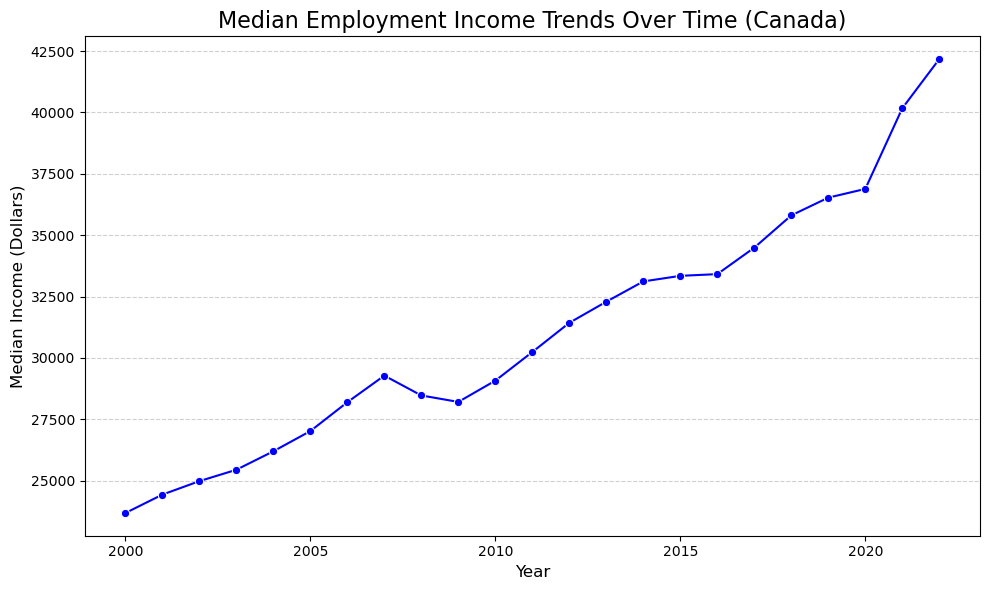

In [24]:
connection = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", connection, index=False, if_exists="replace")

query = """
SELECT
    REF_DATE AS Year,
    AVG(VALUE) AS Median_Income
FROM tax_filers_dataset
WHERE [Canadian tax filers] = 'Median employment income of tax filers'
GROUP BY REF_DATE
ORDER BY Year;
"""

# Fetch the query results into a DataFrame
result_df = pd.read_sql_query(query, connection)

print(result_df)
# Close the SQLite connection
connection.close()

# Convert Year to integers for plotting
result_df['Year'] = result_df['Year'].astype(int)

# Create the visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Median_Income', data=result_df, marker='o', color='blue')

# Add titles and labels
plt.title('Median Employment Income Trends Over Time (Canada)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Income (Dollars)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

**1. Columns Used:**
- REF_DATE: Used as the Year for grouping the data.
- VALUE: Contains the numerical values representing total income, which is aggregated using SUM.
- Canadian tax filers: Used to filter rows where it equals "Total income of tax filers".

**2. Query Explanation:**

- Filter: The WHERE clause ensures only rows with Canadian tax filers = 'Total income of tax filers' are included in the analysis.
- Group By: Groups data by REF_DATE to calculate the total income for each year.
- Aggregate: SUM(VALUE) calculates the total income across all relevant rows for each year.
- Order: Ensures the results are sorted chronologically.

**3. Expected Output:**
- A DataFrame (result) showing the total income contributed by tax filers for each year.
- A line chart visualizing total income over time.

**Visualization (Line Chart):**

- A chart showing how the total income of tax filers changes over the years, with a clear trend.

**Analysis:**

- The graph shows a steady rise in the median employment income in Canada from 2000 to 2021, growing from about $25,000 to over $42,000.
- While income growth slowed slightly during the 2008–2010 financial crisis, the overall trend remained positive, with a notable surge after 2020. This reflects the resilience and progress of Canada’s labor market over the years.

### 2. Which Age Group Has the Highest Tax Filing Compliance Rate?

In [32]:
unique_provinces = df['GEO'].unique()
unique_provinces

array(['Canada', 'Newfoundland and Labrador',
       "St. John's, Newfoundland and Labrador", 'Prince Edward Island',
       'Nova Scotia', 'Halifax, Nova Scotia', 'New Brunswick',
       'Saint John, New Brunswick', 'Quebec', 'Saguenay, Quebec',
       'Québec, Quebec', 'Sherbrooke, Quebec', 'Trois-Rivières, Quebec',
       'Montréal, Quebec', 'Ottawa-Gatineau, Quebec part', 'Ontario',
       'Ottawa-Gatineau, Ontario part', 'Oshawa, Ontario',
       'Toronto, Ontario', 'Hamilton, Ontario',
       'St. Catharines-Niagara, Ontario',
       'Kitchener-Cambridge-Waterloo, Ontario', 'London, Ontario',
       'Windsor, Ontario', 'Greater Sudbury, Ontario',
       'Thunder Bay, Ontario', 'Manitoba', 'Winnipeg, Manitoba',
       'Saskatchewan', 'Regina, Saskatchewan', 'Saskatoon, Saskatchewan',
       'Alberta', 'Calgary, Alberta', 'Edmonton, Alberta',
       'British Columbia', 'Vancouver, British Columbia',
       'Victoria, British Columbia', 'Yukon', 'Northwest Territories',
       'Nuna

In [34]:
provinces = [
    'Canada', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 
    'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia', 'Yukon', 'Northwest Territories', 'Nunavut'
]
province_data = df[df['GEO'].isin(provinces)]
unique_provinces = province_data['GEO'].unique()
print(unique_provinces)

['Canada' 'Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


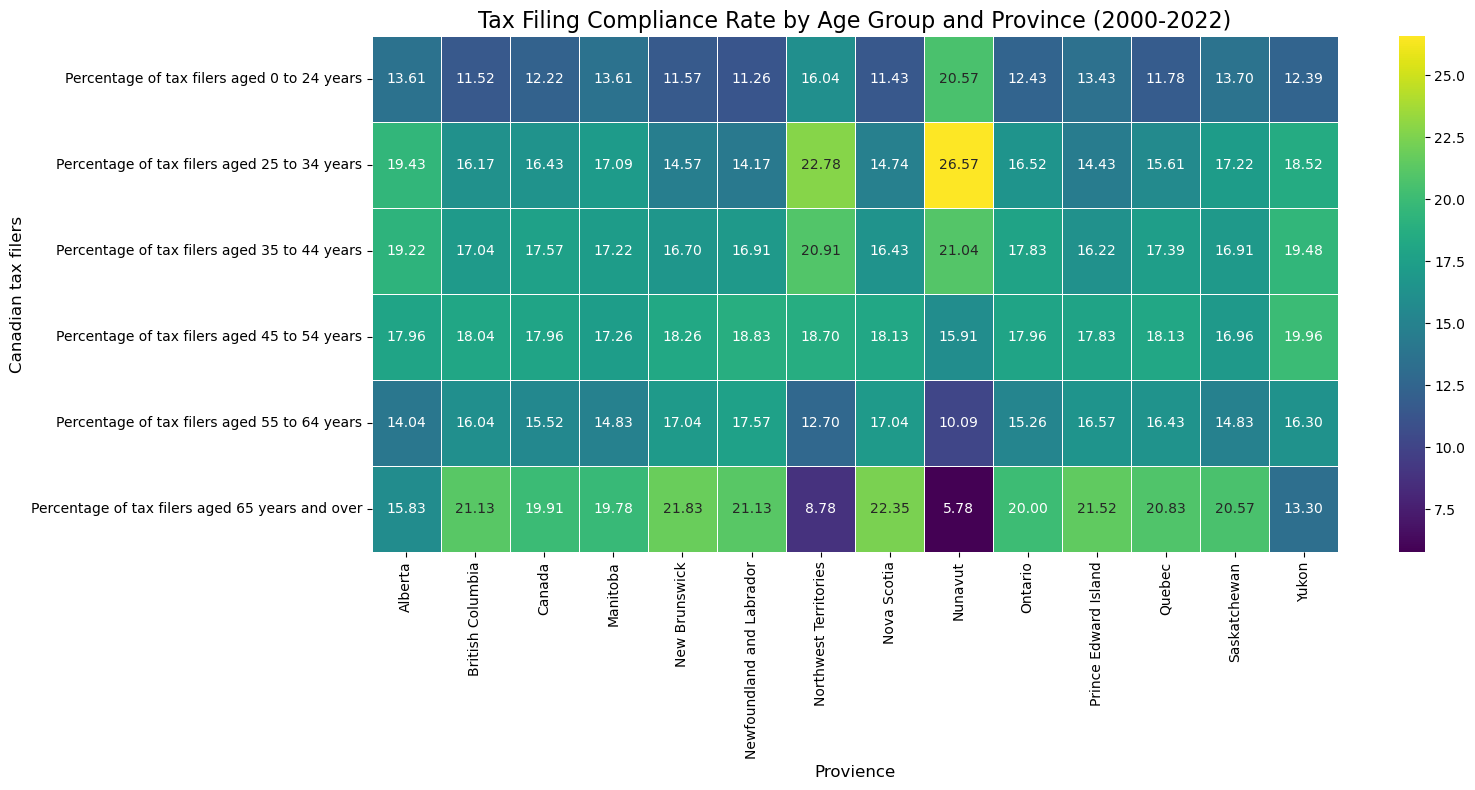

In [36]:
conn = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", conn, index=False, if_exists="replace")

provinces = [
    'Canada', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 
    'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia', 'Yukon', 'Northwest Territories', 'Nunavut'
]

query = f"""
SELECT `REF_DATE`, `Canadian tax filers`, `GEO`, AVG(VALUE) AS Compliance_Rate
FROM tax_filers_dataset
WHERE `Canadian tax filers` LIKE '%aged%' 
  AND `GEO` IN ({', '.join(f"'{prov}'" for prov in provinces)})  
  AND `REF_DATE` BETWEEN 2000 AND 2022  
GROUP BY `REF_DATE`, `Canadian tax filers`, `GEO`
ORDER BY `Canadian tax filers`, `GEO`;
"""

result = pd.read_sql_query(query, conn)
pivot_data = result.pivot_table(index='Canadian tax filers', columns='GEO', values='Compliance_Rate', aggfunc='mean')
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Tax Filing Compliance Rate by Age Group and Province (2000-2022)', fontsize=16)
plt.xlabel('Provience', fontsize=12)
plt.ylabel('Canadian tax filers', fontsize=12)
plt.tight_layout()
plt.show()
conn.close()

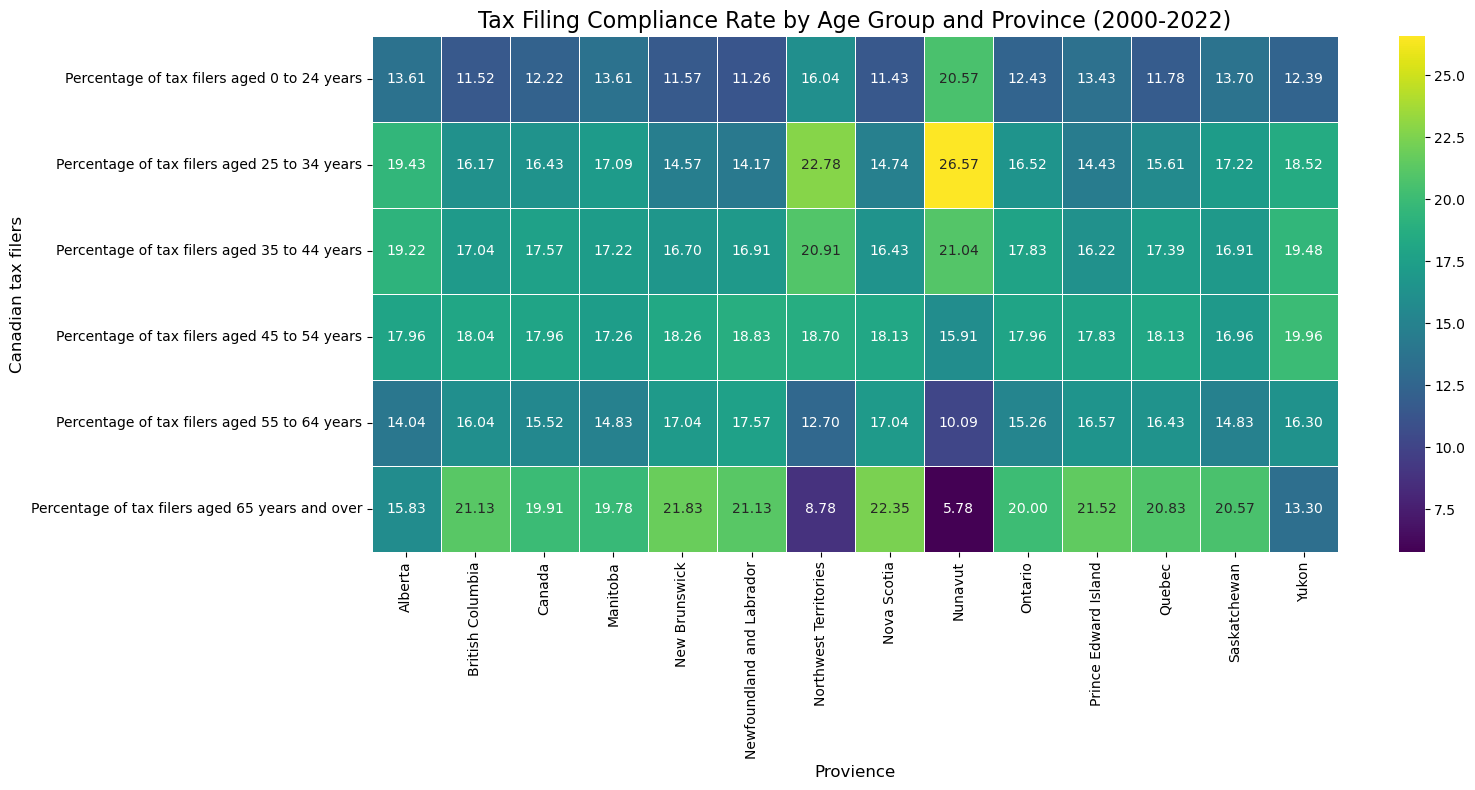

In [37]:
conn = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", conn, index=False, if_exists="replace")

provinces = [
    'Canada', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 'Quebec', 
    'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia', 'Yukon', 'Northwest Territories', 'Nunavut'
]

query = f"""
SELECT `REF_DATE`, `Canadian tax filers`, `GEO`, AVG(VALUE) AS Compliance_Rate
FROM tax_filers_dataset
WHERE `Canadian tax filers` LIKE '%aged%' 
  AND `GEO` IN ({', '.join(f"'{prov}'" for prov in provinces)})  
  AND `REF_DATE` BETWEEN 2000 AND 2022  
GROUP BY `REF_DATE`, `Canadian tax filers`, `GEO`
ORDER BY `Canadian tax filers`, `GEO`;
"""

result = pd.read_sql_query(query, conn)
pivot_data = result.pivot_table(index='Canadian tax filers', columns='GEO', values='Compliance_Rate', aggfunc='mean')
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_data, cmap='viridis', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Tax Filing Compliance Rate by Age Group and Province (2000-2022)', fontsize=16)
plt.xlabel('Provience', fontsize=12)
plt.ylabel('Canadian tax filers', fontsize=12)
plt.tight_layout()
plt.show()
conn.close()

**1. Columns Used:**
- REF_DATE: Represents the year, used for grouping the data by year.
- Canadian tax filers: Represents the age group, used for grouping and filtering age groups related to tax compliance.
- GEO: Represents the province, used to filter and group data by Canadian provinces.
- VALUE: Represents the compliance rate, aggregated using the AVG() function.

**2. Query Explanation:**

**Filter:**
- The WHERE clause filters the data based on three criteria:
- It selects rows where Canadian tax filers includes "aged", indicating the focus on tax filers from certain age groups.
- It filters the GEO (province) column to only include a predefined list of Canadian provinces.
- It restricts the data to the years between 2020 and 2022.

**Group By:**
- Groups the data by REF_DATE (year), Canadian tax filers (age group), and GEO (province) to calculate the average compliance rate per group.

**Aggregate:**
- AVG(VALUE) calculates the average compliance rate across tax filers within each province and age group for each year.

**Order:**
- The ORDER BY clause sorts the results first by Canadian tax filers (age group) and then by GEO (province).

**3.Expected Output:**
    
**DataFrame:**
- The result will be a table showing the average tax filing compliance rate by age group, province, and year. The table will be grouped by year, age group, and province, with each entry representing the average compliance rate.

**Visualization:**
- A heatmap will visualize the compliance rates. The x-axis will represent the provinces, the y-axis will represent the age groups, and the colors will represent the compliance rate, with annotations for the specific values.
- The heatmap is designed to clearly show the differences in compliance rates across provinces and age groups for the years 2000-2022.

**4. Visualization (Heatmap):**

- Heatmap:
A heatmap will be generated, where each cell represents the average compliance rate for a specific combination of age group and province.
The color intensity will reflect the compliance rate, with a color scale indicating the percentage of compliance.
The plot will display with clear labels for provinces, age groups, and an informative title.

**Analysis**

The heatmap illustrates tax filing compliance rates in Canada from 2000 to 2022, segmented by age group and province. Key observations include:

1.	Age-related trends:
- Younger individuals (aged 0–24) consistently exhibit the lowest compliance rates.
- Compliance improves with age, peaking in the middle-aged groups (25–54), while senior citizens (65+) maintain moderate rates.

2.	Regional differences:
- Provinces like British Columbia and Nova Scotia show higher compliance rates across age groups, especially among older adults.
- Territories such as Nunavut and Northwest Territories consistently report lower compliance rates in nearly all categories, with seniors (65+) particularly low in Nunavut (5.78%).

3.	National consistency:
- On a national level, middle-aged Canadians (25–54) have the highest compliance, reflecting their active participation in the workforce.

### 3. Growth in Number of Tax Filers by Province (2000 - 2022)

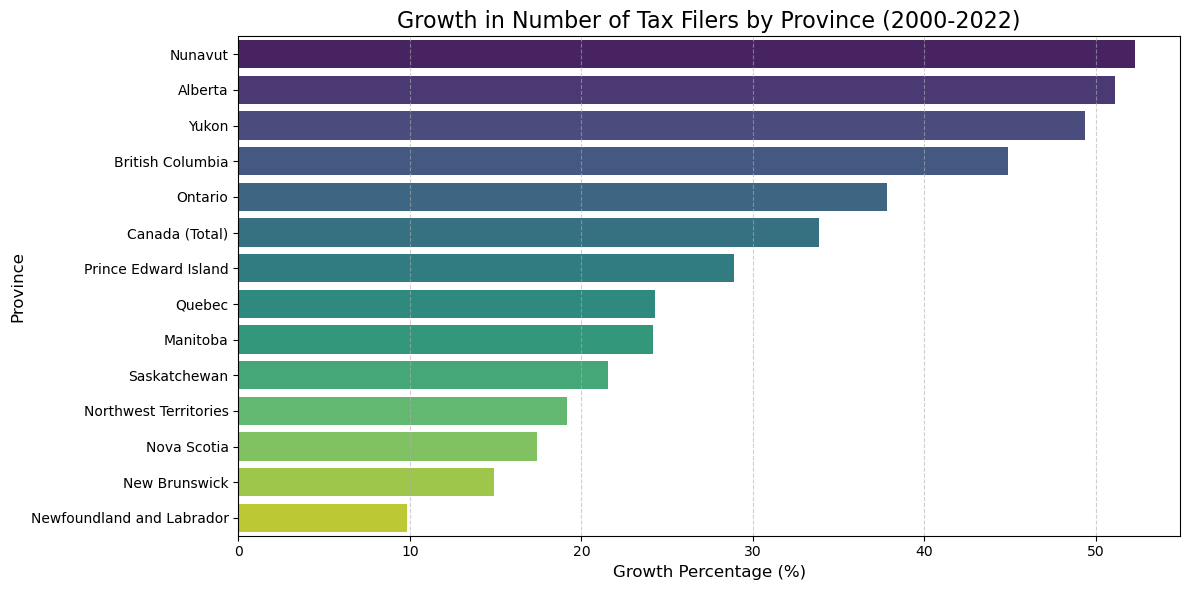

In [45]:
connection = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", connection, index=False, if_exists="replace")

year_start = 2000
year_end = 2022

query = f"""
SELECT
    CASE
        WHEN GEO = 'Canada' THEN 'Canada (Total)'
        ELSE GEO
    END AS Province,
    SUM(CASE WHEN REF_DATE = 2000 THEN VALUE ELSE 0 END) AS Tax_Filers_2000,
    SUM(CASE WHEN REF_DATE = 2022 THEN VALUE ELSE 0 END) AS Tax_Filers_2022,
    ROUND(((SUM(CASE WHEN REF_DATE = 2022 THEN VALUE ELSE 0 END) - SUM(CASE WHEN REF_DATE = 2000 THEN VALUE ELSE 0 END)) / 
           SUM(CASE WHEN REF_DATE = 2000 THEN VALUE ELSE 0 END)) * 100, 2) AS Growth_Percentage
FROM tax_filers_dataset
WHERE [Canadian tax filers] = 'Number of tax filers'
  AND GEO IN ('Canada', 'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick', 
              'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia', 
              'Yukon', 'Northwest Territories', 'Nunavut')
GROUP BY GEO
ORDER BY Growth_Percentage DESC;
"""

growth_percentage_df = pd.read_sql_query(query, connection)
connection.close()


plt.figure(figsize=(12, 6))
sns.barplot(x="Growth_Percentage", y="Province", data=growth_percentage_df, palette="viridis", hue="Province", legend=False)

plt.title(f"Growth in Number of Tax Filers by Province ({year_start}-{year_end})", fontsize=16)
plt.xlabel("Growth Percentage (%)", fontsize=12)
plt.ylabel("Province", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**1. Columns Used:**
- REF_DATE: Year of data.
- Canadian tax filers: Filters for the "Number of tax filers."
- GEO: Province.
- VALUE: Number of tax filers, summed for each year (2000 and 2022).
  
**2. Query Explanation:**
- SUM and CASE: The query uses CASE WHEN to conditionally sum the number of tax filers for the years 2000 and 2022.
- Growth Calculation: Computes the percentage growth in tax filers between 2000 and 2022 by comparing the summed values for each year.
- GROUP BY: Groups the data by province to calculate the totals for each one.
- ORDER BY: Sorts the results by growth percentage in descending order to highlight the provinces with the highest growth.
  
**3. Expected Output:**
- DataFrame: Displays the tax filers for 2000, 2022, and the calculated growth percentage for each province.
- Visualization: Bar plot showing growth percentages across provinces, with the provinces sorted by the highest growth.
  
**4. Visualization (Bar Plot):**
- A horizontal bar plot that visualizes the growth percentage in tax filers from 2000 to 2022, sorted by the highest growth percentage.

**Analysis**

The bar chart displays the growth percentage in the number of tax filers across Canadian provinces and territories from 2000 to 2022.

1.	Highest Growth:
- Nunavut leads with the highest growth percentage in tax filers, exceeding 50%, likely driven by population growth and increased economic activity in the region.
- Alberta follows with significant growth, reflecting its robust economy during this period.

2.	Strong Growth Regions:
- Territories like Yukon and provinces such as British Columbia and Ontario also show notable growth rates, surpassing the national average.

3.	Moderate Growth:
- Provinces like Quebec, Manitoba, and Saskatchewan display moderate growth, hovering around 20–30%.

4.	Lowest Growth:
- Newfoundland and Labrador and New Brunswick show the least growth in tax filers, with rates below 20%, possibly linked to slower population growth or economic challenges.

### 4. Employment Income vs. Total Income(Particular Alberta)

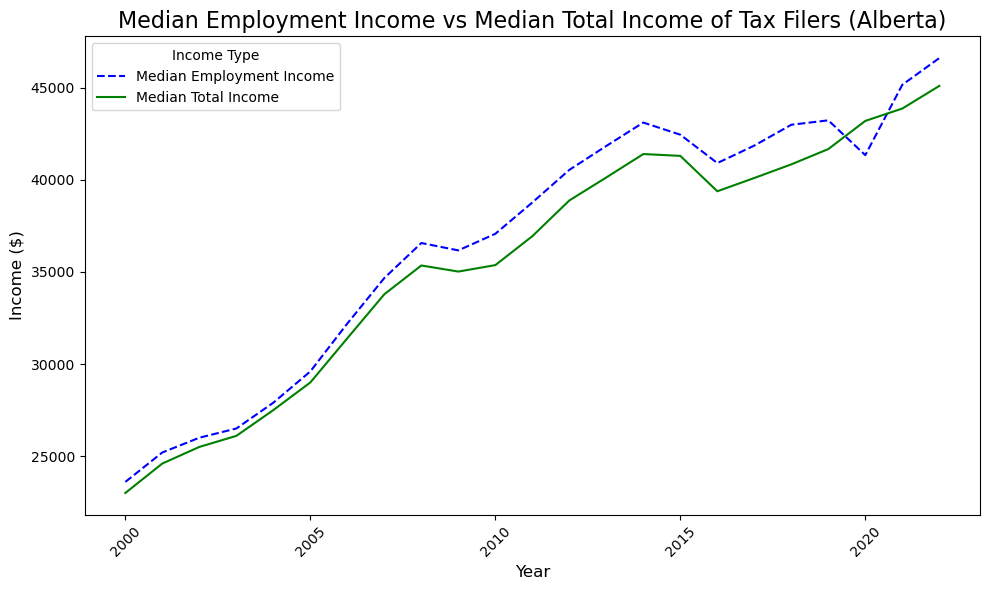

In [50]:
connection = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", connection, index=False, if_exists="replace")

query = """
SELECT "REF_DATE", "GEO", 
       AVG(CASE WHEN "Canadian tax filers" = 'Median employment income of tax filers' THEN "VALUE" END) AS "Median_Employment_Income",
       AVG(CASE WHEN "Canadian tax filers" = 'Median total income of tax filers' THEN "VALUE" END) AS "Median_Total_Income"
FROM "tax_filers_dataset"
WHERE "GEO" = 'Alberta'
GROUP BY "REF_DATE", "GEO";
"""

result_df = pd.read_sql_query(query, connection)
connection.close()

result_df['REF_DATE'] = result_df['REF_DATE'].astype(int)

plt.figure(figsize=(10, 6))
plt.plot(result_df['REF_DATE'], result_df['Median_Employment_Income'], label='Median Employment Income', linestyle='--', color='blue')
plt.plot(result_df['REF_DATE'], result_df['Median_Total_Income'], label='Median Total Income', color='green')

plt.title('Median Employment Income vs Median Total Income of Tax Filers (Alberta)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Income ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Income Type')

plt.tight_layout()
plt.show()

**Employment Income:**

- The income earned from work or job-related activities.
- Includes salary, wages, bonuses, and self-employment earnings.

**Total Income:**

- The total income from all sources, including Employment Income plus other sources like investment income, rental income, and government benefits.

**Key Difference:**

- Employment Income is just part of Total Income. Total Income includes employment earnings as well as income from other sources like investments, pensions, and benefits.

**1. Columns Used:**

- REF_DATE: Year of the data.
- GEO: Region/Province (specifically, Alberta).
- Canadian tax filers: Filters for specific categories of tax filers (e.g., Median employment income of tax filers, Median total income of tax filers).
- VALUE: Represents the income values for the specific categories of tax filers.

**2. Query Explanation:**

- AVG and CASE: The query calculates the average income for each year for two types of tax filers:
- Median employment income of tax filers.
- Median total income of tax filers.
- GROUP BY: Groups the data by REF_DATE (year) and GEO (region), so it calculates the average for each year (2000, 2022) for Alberta.
- WHERE: Filters the data for the region Alberta.

**3. Expected Output:**

- DataFrame: The resulting DataFrame (result_df) will contain the average median employment income and median total income for each year in Alberta.
- Visualization: A line plot showing the trends for both Median Employment Income and Median Total Income for tax filers over the years,  with different lines for each income type.

**4. Visualization (Line Plot):**

- A line plot showing the trends in Median Employment Income (dashed blue line) and Median Total Income (solid green line) over time (from 2000 to 2022) for Alberta.
- The x-axis represents the year (REF_DATE), and the y-axis represents the income values in dollars.

**Analysis**

The line plot shows rising trends in median employment and total income for tax filers in Alberta from 2000 to 2022. Key insights include:
- Income Growth: Both income types trend upward, indicating overall wage growth.
- Employment vs. Total Income: Up until 2015, they align closely, then employment income trends slightly higher, suggesting increased earnings from employment.
- Fluctuations: Between 2015-2020, there are plateaus and slight declines, possibly due to economic challenges, followed by a sharp recovery post-2020.

Overall, this highlights Alberta's income growth over time, with economic impacts visible in specific periods.

### 5. Percentage of Total Income from Tax Filers Earning Less Than $20,000 by Provience

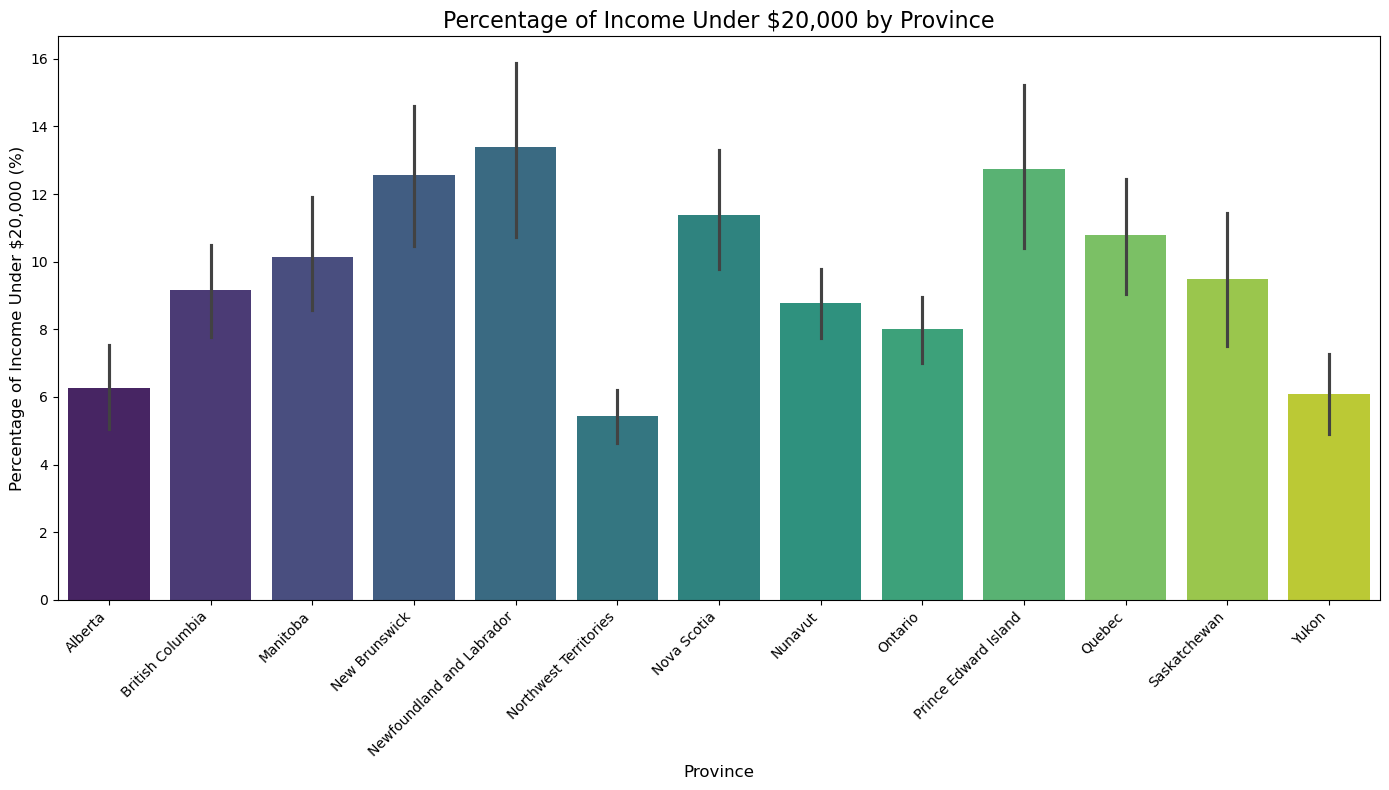

In [56]:
connection = sqlite3.connect(":memory:")
df.to_sql("tax_filers_dataset", connection, index=False, if_exists="replace")

query = """
SELECT 
    GEO, 
    VALUE AS pct_income_under_20000
FROM 
    tax_filers_dataset
WHERE 
    `Canadian tax filers` = 'Percentage of aggregate total income reported by tax filers with total income of less than $20,000'
    AND UOM = 'Percent'
    AND GEO IN ('Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 'New Brunswick',
                'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'Alberta', 'British Columbia',
                'Yukon', 'Northwest Territories', 'Nunavut')
ORDER BY 
    GEO;
"""

filtered_df = pd.read_sql(query, connection)
connection.close()

plt.figure(figsize=(14, 8))
sns.barplot(x='GEO', y='pct_income_under_20000', data=filtered_df, hue='GEO', palette='viridis')
plt.title('Percentage of Income Under $20,000 by Province',fontsize =16)
plt.xlabel('Province',fontsize =12)
plt.ylabel('Percentage of Income Under $20,000 (%)',fontsize =12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**1. Columns Used:**

- GEO: Region/Province (e.g., Alberta).
- VALUE: Percentage of tax filers with income under 20,000 dollars.
- Canadian tax filers: Filters data for specific categories like tax filers with income under 20,000dollars.
- UOM: Unit of Measure (Percent).

**2. Query Explanation:**

- SELECT: Retrieves GEO and VALUE (percentage of tax filers under 20,000 dollars).
- WHERE: Filters data for tax filers with income under 20,000 dollars, excluding 'Canada' and focusing on provinces.
- ORDER BY GEO: Orders results by region for clarity.
  
**3. Expected Output:**

- DataFrame: Contains provinces and their percentage of tax filers with income under 20,000 dollars.
- Visualization: A bar plot showing the percentage for each province.
  
**4. Visualization (Bar Plot):**

- Bar plot displaying the percentage of tax filers with income under 20,000 dollars for each province.
- x axis: Provinces.
- y axis: Percentage of tax filers under 20,000 dollars.
- Bars are colored by province for differentiation.

**Analysis**

The bar plot highlights the percentage of tax filers with income under $20,000 across Canadian regions:

- High Percentages: Nova Scotia, Newfoundland and Labrador, and Nunavut have the highest rates (above 12%), possibly indicating economic challenges in these areas.
- Low Percentages: Alberta, Northwest Territories, and Yukon show lower rates (around 6-8%), suggesting stronger income levels.

This variation reflects regional economic differences, with some provinces having a higher concentration of low-income earners.



### Overall Conclusion

The data shows clear differences in tax filing trends across Canada, influenced by both age and location. Regions like Nunavut and Alberta have seen the biggest growth in tax filers, likely due to population increases and economic opportunities. Middle-aged Canadians (25–54) are the most consistent tax filers, while younger people and seniors file less often. Remote areas, such as Nunavut and the Northwest Territories, struggle with lower filing rates, especially among older residents.

This highlights the need for targeted efforts to improve tax filing in regions and age groups with lower participation. By raising awareness, improving access, and addressing regional challenges, Canada can create a fairer and more efficient tax system.

Further cleaning for Group Project

In [ ]:
df_1 = df.copy()

In [73]:
df_1.head()

,REF_DATE,GEO,DGUID,Canadian tax filers,UOM,UOM_ID,VALUE
0,2000,Canada,2021A000011124,Number of tax filers,Number,223,21611830.0
1,2000,Canada,2021A000011124,Percentage of tax filers reporting in French,Percent,239,23.0
2,2000,Canada,2021A000011124,Average age of tax filers,Years,308,45.0
3,2000,Canada,2021A000011124,Percentage of tax filers aged 0 to 24 years,Percent,239,13.0
4,2000,Canada,2021A000011124,Percentage of tax filers aged 25 to 34 years,Percent,239,17.0


In [75]:
df_1= df_1.dropna(subset=['VALUE'])
df_1.head()

,REF_DATE,GEO,DGUID,Canadian tax filers,UOM,UOM_ID,VALUE
0,2000,Canada,2021A000011124,Number of tax filers,Number,223,21611830.0
1,2000,Canada,2021A000011124,Percentage of tax filers reporting in French,Percent,239,23.0
2,2000,Canada,2021A000011124,Average age of tax filers,Years,308,45.0
3,2000,Canada,2021A000011124,Percentage of tax filers aged 0 to 24 years,Percent,239,13.0
4,2000,Canada,2021A000011124,Percentage of tax filers aged 25 to 34 years,Percent,239,17.0


In [83]:
df_1 = df_1[df_1['UOM'].str.lower().str.contains('percent', na=False)]

In [85]:
df_1= df_1[(df_1['REF_DATE'] >= 2017) & (df_1['REF_DATE'] <= 2022)]

In [93]:
provinces = [
    'Newfoundland and Labrador', 'Prince Edward Island', 'Nova Scotia', 
    'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 
    'Alberta', 'British Columbia', 'Yukon', 'Northwest Territories', 'Nunavut'
]

# Filter rows with only province names in the GEO column
df_1 = df_1[df_1['GEO'].isin(provinces)]

In [95]:
df_1

,REF_DATE,GEO,DGUID,Canadian tax filers,UOM,UOM_ID,VALUE
43663,2017,Newfoundland and Labrador,2021A000210,Percentage of tax filers aged 0 to 24 years,Percent,239,10.0
43664,2017,Newfoundland and Labrador,2021A000210,Percentage of tax filers aged 25 to 34 years,Percent,239,13.0
43665,2017,Newfoundland and Labrador,2021A000210,Percentage of tax filers aged 35 to 44 years,Percent,239,14.0
43666,2017,Newfoundland and Labrador,2021A000210,Percentage of tax filers aged 45 to 54 years,Percent,239,18.0
43667,2017,Newfoundland and Labrador,2021A000210,Percentage of tax filers aged 55 to 64 years,Percent,239,20.0
...,...,...,...,...,...,...,...
69209,2022,Nunavut,2021A000262,Percentage of aggregate total income reported ...,Percent,239,5.0
69210,2022,Nunavut,2021A000262,Percentage of aggregate total income reported ...,Percent,239,9.0
69211,2022,Nunavut,2021A000262,Percentage of aggregate total income reported ...,Percent,239,8.0
69212,2022,Nunavut,2021A000262,Percentage of aggregate total income reported ...,Percent,239,9.0


# Wages, salaries and commissions of tax filers

For this part, I will merge two sub datasets of this topic. Following are the two datasets that I will be combining to perform my analysis:

Wages, salaries and commissions of tax filers aged 15 years and over by sex and age group. Available at https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110007201

Wages, salaries and commissions of tax filers aged 15 years and over by main industry sector and sex. Available at https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110007301

First I will load the dataset and explore the columns that need to be removed, and after that I will clean the datasets individually. After doing so, I will merge the datasets into on with some commpn columns and then answer the guiding questions with the help op SQL queries.

In [4]:
import pandas as pd
import sqlalchemy as sq
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sex_age_df = pd.read_csv('Sex and age group.csv')
industry_df = pd.read_csv('Main industry sector.csv')

C:\Users\Vineet Patel\AppData\Local\Temp\ipykernel_26688\3857408294.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  sex_age_df = pd.read_csv('Sex and age group.csv')
C:\Users\Vineet Patel\AppData\Local\Temp\ipykernel_26688\3857408294.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  industry_df = pd.read_csv('Main industry sector.csv')


Let's clean the sex_age_df

In [3]:
sex_age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160704 entries, 0 to 160703
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   REF_DATE       160704 non-null  int64  
 1   GEO            160704 non-null  object 
 2   DGUID          160704 non-null  object 
 3   Sex            160704 non-null  object 
 4   Age group      160704 non-null  object 
 5   Statistics     160704 non-null  object 
 6   UOM            160704 non-null  object 
 7   UOM_ID         160704 non-null  int64  
 8   SCALAR_FACTOR  160704 non-null  object 
 9   SCALAR_ID      160704 non-null  int64  
 10  VECTOR         160704 non-null  object 
 11  COORDINATE     160704 non-null  object 
 12  VALUE          160377 non-null  float64
 13  STATUS         327 non-null     object 
 14  SYMBOL         0 non-null       float64
 15  TERMINATED     2880 non-null    object 
 16  DECIMALS       160704 non-null  int64  
dtypes: float64(2), int64(4), obje

Columns like 'SYMBOL', 'STATUS', 'TERMINATED', 'VECTOR', 'COORDINATE', 'SCALAR_FACTOR', 'SCALAR_ID', 'DECIMALS' appear unnecessary here, so I will drop them.

In [4]:
cleaned_sex_age_df = sex_age_df.drop(columns=['SYMBOL', 'STATUS', 'TERMINATED', 'VECTOR', 'COORDINATE', 'SCALAR_FACTOR', 'SCALAR_ID', 'DECIMALS'], errors='ignore')

Now we will remove all the rows where "VALUE" is Null.

In [5]:
cleaned_sex_age_df = cleaned_sex_age_df.dropna(subset=['VALUE'])

Will remove any duplicated rows if any.

In [6]:
cleaned_sex_age_df = cleaned_sex_age_df.drop_duplicates()

Now we will do the same thing for industry_df

In [8]:
industry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142848 entries, 0 to 142847
Data columns (total 16 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   REF_DATE                                                                          142848 non-null  int64  
 1   GEO                                                                               142848 non-null  object 
 2   DGUID                                                                             142848 non-null  object 
 3   Main industry based on the North American Industry Classification System (NAICS)  142848 non-null  object 
 4   Statistics                                                                        142848 non-null  object 
 5   UOM                                                                               142848 non-null  o

Columns like 'SYMBOL', 'STATUS', 'TERMINATED', 'VECTOR', 'COORDINATE', 'SCALAR_FACTOR', 'SCALAR_ID', 'DECIMALS' appear unnecessary here, so I will drop them.

In [9]:
cleaned_industry_df = industry_df.drop(columns=['SYMBOL', 'STATUS', 'TERMINATED', 'VECTOR', 'COORDINATE', 'SCALAR_FACTOR', 'SCALAR_ID', 'DECIMALS'], errors='ignore')

Now we will remove all the rows where "VALUE" is Null.

In [10]:
cleaned_industry_df = cleaned_industry_df.dropna(subset=['VALUE'])

Will rename the column to make it easier to extract Industry data.

In [12]:
cleaned_industry_df.rename(columns={'Main industry based on the North American Industry Classification System (NAICS)': 'Industry'}, inplace=True)

Removing all the rows where Industry = Not Available

In [13]:
cleaned_industry_df =cleaned_industry_df[cleaned_industry_df['Industry'] !='Not available']

We will not consider the rows where the data for Industry column is Not Available

In [14]:
cleaned_industry_df =cleaned_industry_df[cleaned_industry_df['Industry'] !='All industries']

Now that we have clean data, We will merge them together

In [21]:
merged_df = pd.merge(cleaned_sex_age_df, cleaned_industry_df, 
                     on=['REF_DATE', 'GEO', 'DGUID', 'Statistics', 'UOM', 'UOM_ID', 'VALUE'], 
                     how='inner')

For my analysis, I am only going to analyse the value in terms of Dollars. Therefore, I will only keep the data where UOM is DOllars.

In [22]:
merged_df = merged_df[merged_df['UOM'] == 'Dollars']

Now, let's save the file to a new csv

In [23]:
merged_df.to_csv('wage.csv', index = False)

NOw, will copy the dataframe to new variable

In [24]:
wages_df = merged_df.copy()

As I am going to focus on the provience data, I will apply some mapping function to convert the data present in GEO column to respective provience.

In [ ]:
# Mapping dictionary for 'GEO' column to provinces
geo_to_province = {
    'Lethbridge, Alberta': 'Alberta',
    'Non CMA-CA, Nova Scotia': 'Nova Scotia',
    'Swift Current, Saskatchewan': 'Saskatchewan',
    'Thompson, Manitoba': 'Manitoba',
    'Miramichi, New Brunswick': 'New Brunswick',
    'Salaberry-de-Valleyfield, Quebec': 'Quebec',
    'Kentville, Nova Scotia': 'Nova Scotia',
    'Winkler, Manitoba': 'Manitoba',
    'Campbellton, combined NewBrunswick/Quebec': 'New Brunswick',
    'Dawson Creek, British Columbia': 'British Columbia',
    'Prince Rupert, British Columbia': 'British Columbia',
    'Lloydminster, combined Alberta/Saskatchewan': 'Alberta/Saskatchewan',
    'Alma, Quebec': 'Quebec',
    'Belleville-Quinte West, Ontario': 'Ontario',
    'Hawkesbury, combined Ontario/Quebec': 'Ontario',
    'Kenora, Ontario': 'Ontario',
    'Prince George, British Columbia': 'British Columbia',
    'Midland, Ontario': 'Ontario',
    'Prince Edward Island': 'Prince Edward Island',
    'Rimouski, Quebec': 'Quebec',
    'Carleton Place, Ontario': 'Ontario',
    'Centre Wellington, Ontario': 'Ontario',
    'Cowansville, Quebec': 'Quebec',
    'Hawkesbury, Quebec part': 'Quebec',
    'Moncton, New Brunswick': 'New Brunswick',
    'Non CMA-CA, Alberta': 'Alberta',
    'Nova Scotia': 'Nova Scotia',
    'Medicine Hat, Alberta': 'Alberta',
    'Non CMA-CA, British Columbia': 'British Columbia',
    'Squamish, British Columbia': 'British Columbia',
    'Penticton, British Columbia': 'British Columbia',
    'Shawinigan, Quebec': 'Quebec',
    'Saint-Georges, Quebec': 'Quebec',
    'Quebec': 'Quebec',
    'Lloydminster, Saskatchewan part': 'Saskatchewan',
    'Rouyn-Noranda, Quebec': 'Quebec',
    'St. John\'s, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Joliette, Quebec': 'Quebec',
    'Trois-Rivières, Quebec': 'Quebec',
    'North Battleford, Saskatchewan': 'Saskatchewan',
    'Cobourg, Ontario': 'Ontario',
    'Cranbrook, British Columbia': 'British Columbia',
    'Salmon Arm, British Columbia': 'British Columbia',
    'Abbotsford-Mission, British Columbia': 'British Columbia',
    'Grand Falls-Windsor, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Corner Brook, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Drummondville, Quebec': 'Quebec',
    'Nanaimo, British Columbia': 'British Columbia',
    'Thetford Mines, Quebec': 'Quebec',
    'Truro, Nova Scotia': 'Nova Scotia',
    'Vancouver, British Columbia': 'British Columbia',
    'Non CMA-CA, Prince Edward Island': 'Prince Edward Island',
    'Yorkton, Saskatchewan': 'Saskatchewan',
    'Woodstock, Ontario': 'Ontario',
    'Norfolk, Ontario': 'Ontario',
    'Bay Roberts, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Courtenay, British Columbia': 'British Columbia',
    'Rivière-du-loup, Quebec': 'Quebec',
    'Strathmore, Alberta': 'Alberta',
    'Campbellton, Quebec part': 'Quebec',
    'Kelowna, British Columbia': 'British Columbia',
    'Manitoba': 'Manitoba',
    'Saskatchewan': 'Saskatchewan',
    'Stratford, Ontario': 'Ontario',
    'Camrose, Alberta': 'Alberta',
    'Non CMA-CA, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Parksville, British Columbia': 'British Columbia',
    'St. Catharines-Niagara, Ontario': 'Ontario',
    'Timmins, Ontario': 'Ontario',
    'Ottawa-Gatineau, combined Ontario/Quebec': 'Ontario/Quebec',
    'Sainte-Marie, Quebec': 'Quebec',
    'Lachute, Quebec': 'Quebec',
    'British Columbia': 'British Columbia',
    'Halifax, Nova Scotia': 'Nova Scotia',
    'New Glasgow, Nova Scotia': 'Nova Scotia',
    'Powell River, British Columbia': 'British Columbia',
    'Quesnel, British Columbia': 'British Columbia',
    'Kitchener-Cambridge-Waterloo, Ontario': 'Ontario',
    'North Bay, Ontario': 'Ontario',
    'Okotoks, Alberta': 'Alberta',
    'Wetaskiwin, Alberta': 'Alberta',
    'Williams Lake, British Columbia': 'British Columbia',
    'Collingwood, Ontario': 'Ontario',
    'Kingston, Ontario': 'Ontario',
    'Montréal, Quebec': 'Quebec',
    'Yukon': 'Yukon',
    'Brooks, Alberta': 'Alberta',
    'New Brunswick': 'New Brunswick',
    'Nunavut': 'Nunavut',
    'Elliot Lake, Ontario': 'Ontario',
    'Greater Sudbury, Ontario': 'Ontario',
    'Gander, Newfoundland and Labrador': 'Newfoundland and Labrador',
    'Kamloops, British Columbia': 'British Columbia',
    'Non CMA-CA, Manitoba': 'Manitoba',
    'Non CMA-CA, Yukon': 'Yukon',
    'Pembroke, Ontario': 'Ontario',
    'Saskatoon, Saskatchewan': 'Saskatchewan',
    'Calgary, Alberta': 'Alberta',
    'Summerside, Prince Edward Island': 'Prince Edward Island',
    'Lacombe, Alberta': 'Alberta',
    'Canada': 'Canada',
    'Guelph, Ontario': 'Ontario',
    'Port Hope, Ontario': 'Ontario',
    'Tillsonburg, Ontario': 'Ontario',
    'Cape Breton, Nova Scotia': 'Nova Scotia',
    'Non CMA-CA, Saskatchewan': 'Saskatchewan',
    'Brandon, Manitoba': 'Manitoba',
    'Sylvan Lake, Alberta': 'Alberta',
    'Edmonton, Alberta': 'Alberta',
    'Prince Albert, Saskatchewan': 'Saskatchewan',
    'Fredericton, New Brunswick': 'New Brunswick',
    'Campbellton, New Brunswick part': 'New Brunswick',
    'Grande Prairie, Alberta': 'Alberta',
    'Nelson, British Columbia': 'British Columbia',
    'Baie-Comeau, Quebec': 'Quebec',
    'Cold Lake, Alberta': 'Alberta',
    'Granby, Quebec': 'Quebec',
    'Edmundston, New Brunswick': 'New Brunswick',
    'Hawkesbury, Ontario part': 'Ontario',
    'Non CMA-CA, New Brunswick': 'New Brunswick',
    'Victoria, British Columbia': 'British Columbia',
    'Peterborough, Ontario': 'Ontario',
    'Québec, Quebec': 'Quebec',
    'Campbell River, British Columbia': 'British Columbia',
    'Orillia, Ontario': 'Ontario',
    'Portage la Prairie, Manitoba': 'Manitoba',
    'Hamilton, Ontario': 'Ontario',
    'Non CMA-CA, Ontario': 'Ontario',
    'Saguenay, Quebec': 'Quebec',
    'Steinbach, Manitoba': 'Manitoba',
    'Sorel-Tracy, Quebec': 'Quebec',
    'Sarnia, Ontario': 'Ontario',
    'London, Ontario': 'Ontario',
    'Charlottetown, Prince Edward Island': 'Prince Edward Island',
    'Owen Sound, Ontario': 'Ontario',
    'Bathurst, New Brunswick': 'New Brunswick',
    'Cornwall, Ontario': 'Ontario',
    'Essa, Ontario': 'Ontario',
    'Terrace, British Columbia': 'British Columbia',
    'Toronto, Ontario': 'Ontario',
    'Brockville, Ontario': 'Ontario',
    'Winnipeg, Manitoba': 'Manitoba',
    'High River, Alberta': 'Alberta',
    'Saint John, New Brunswick': 'New Brunswick',
    'Ottawa-Gatineau, Ontario part': 'Ontario',
    'Ottawa-Gatineau, Quebec part': 'Quebec',
    'Ladysmith, British Columbia': 'British Columbia',
    'Chilliwack, British Columbia': 'British Columbia',
    'Petawawa, Ontario': 'Ontario',
    'Brantford, Ontario': 'Ontario',
    'Canmore, Alberta': 'Alberta',
    'Estevan, Saskatchewan': 'Saskatchewan',
    'Windsor, Ontario': 'Ontario',
    'Non CMA-CA, Quebec': 'Quebec',
    'Sherbrooke, Quebec': 'Quebec',
    'Saint-Hyacinthe, Quebec': 'Quebec',
    'Fort St. John, British Columbia': 'British Columbia',
    'Ontario': 'Ontario',
    'Moose Jaw, Saskatchewan': 'Saskatchewan'
}

# Apply the mapping to the 'GEO' column to get province names
wages_df['GEO'] = wages_df['GEO'].map(geo_to_province)

Now that I have the dataframe ready to work in sql, I will use sqlite3.connect() to establishes a connection to an SQLite database on my local device.

In [5]:
engine = sqlite3.connect('wages_dataset.db')

Now, the database is connected, I will insert a table.

In [29]:
wages_df.to_sql('wages_dataset', engine, index=False, if_exists='replace')
print('Table Created')

Table Created


Now, we will answer the guiding question:

**What role do demographic factors (age, sex, province) play in explaining wage disparities across industries, and how have these disparities changed over time?**


This guiding question can be solved by following sub questions:

1. Wage Gap by Provience, Industry, and Age Group: Identify how wage gaps differ based on location, Industry and Age.

2. Wage Gap Change Over Time by Provience: Track how the wage gap between males and females has changed in different proviences over the years.

3. Wage Disparity by Age Group and Industry: Identify which age groups experience the largest wage disparities and how this varies across industries.

4. Average Wages by Sex in Each Industry Over Time: Compare how the average wages for males and females evolve within the same industry over time.

Before addressing these sub queries, I will find Average Wages by Age, Sex and Industries using following SQL query:

In [6]:
avg_query1 = '''SELECT 
    "Age group", 
    Sex,
    AVG(VALUE) AS Avg_Wages
FROM wages_dataset
GROUP BY "Age group", Sex
ORDER BY "Age group", Sex;'''

In [26]:
avg_query1_res = pd.read_sql_query(avg_query1, engine)
avg_query1_res = avg_query1_res[(avg_query1_res['Sex']=='Males') | (avg_query1_res['Sex'] == 'Females')]
avg_query1_res

,Age group,Sex,Avg_Wages
1,15 to 24 years,Females,9091.333333
2,15 to 24 years,Males,13217.368421
4,25 to 34 years,Females,26443.333333
5,25 to 34 years,Males,43855.217391
7,35 to 44 years,Females,40710.526316
8,35 to 44 years,Males,73991.666667
10,45 to 54 years,Females,46508.636364
11,45 to 54 years,Males,65506.000000
13,55 to 64 years,Females,43564.615385
14,55 to 64 years,Males,37031.666667


Let's Visualize the data

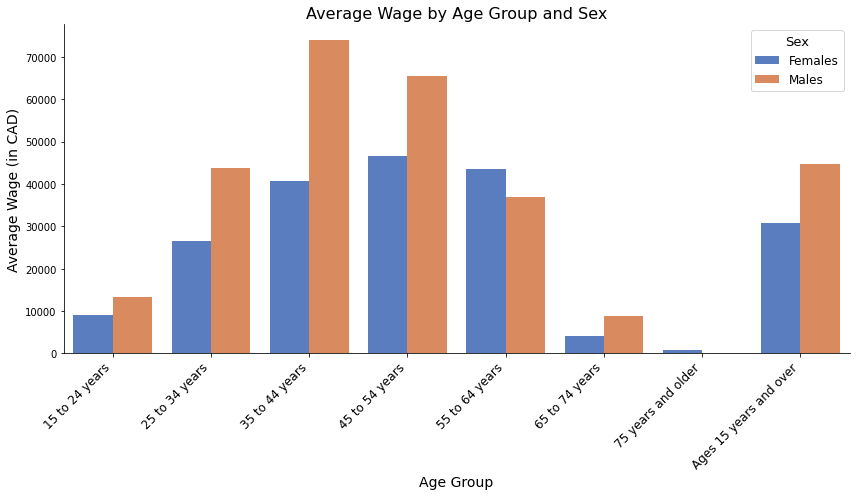

In [27]:
plt.figure(figsize=(12, 7))

sns.set_palette("muted")

ax = sns.barplot(data=avg_query1_res, x='Age group', y='Avg_Wages', hue='Sex', dodge=True, errorbar=None)

ax.set_title('Average Wage by Age Group and Sex', fontsize=16)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_ylabel('Average Wage (in CAD)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.legend(title='Sex', fontsize=12, title_fontsize=13)

ax.grid(False)
sns.despine()

plt.tight_layout()

plt.show()

- The bar graph highlights that the average wages increase with age, peaking in the middle-aged groups, and then declining slightly for older age groups. This trend reflects how wages tend to align with career progression, experience, and eventual tapering towards retirement.

- The average wages for males consistently exceed those for females across all age groups. The highest wages are observed for males in middle age groups, reflecting a peak in career earnings.

- The gender wage gap is evident and persistent. In each age group, males earn higher average wages than females. This disparity may indicate unequal access to high-paying roles, differences in career progression, or systemic biases.

- For older age groups, both male and female wages decline, though the gap remains. This likely reflects reduced work hours or retirement, with a smaller gender gap potentially due to fewer individuals remaining in the workforce.

Now, let's have a look on wages by industry

In [28]:
avg_query2 = '''SELECT 
    Industry,  
    AVG(VALUE) AS Avg_Wages
FROM wages_dataset
GROUP BY Industry
ORDER BY Industry;'''

In [29]:
avg_query2_res = pd.read_sql_query(avg_query2, engine)
avg_query2_res

,Industry,Avg_Wages
0,Accommodation and food services [72],13024.838710
1,"Administrative and support, waste management a...",14750.000000
2,"Agriculture, forestry, fishing and hunting [11]",21494.166667
3,"Arts, entertainment and recreation [71]",12368.421053
4,"Business, building and other support services ...",20808.571429
5,Construction [23],37867.142857
6,Educational services [61],56634.814815
7,Finance and insurance [52],13635.087719
8,Health care and social assistance [62],41305.600000
9,Information and cultural industries [51],50514.117647


C:\Users\Vineet Patel\AppData\Local\Temp\ipykernel_13404\1232692635.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_Wages', y='Industry', data=avg_query2_res, palette='viridis')


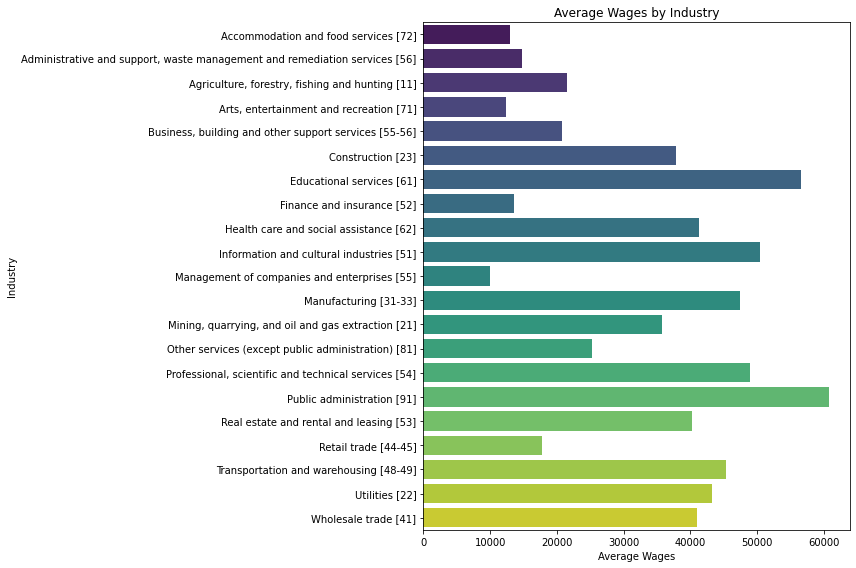

In [32]:
plt.figure(figsize=(12, 8))

sns.barplot(x='Avg_Wages', y='Industry', data=avg_query2_res, palette='viridis')

plt.xlabel('Average Wages')
plt.ylabel('Industry')
plt.title('Average Wages by Industry')

plt.tight_layout()
plt.show()

- The average wages vary significantly across industries. Some industries consistently pay higher average wages, likely reflecting demand for specialized skills or higher profitability.

- Industries like ["finance" or "technology"] appear to offer the highest wages, while others ["service" or "hospitality"] rank lower. These differences could reflect the varying economic value, skills required, or labor supply characteristics of each sector.

Following Conclusion can be made:

1. Wages Across Age Groups: Wages increase with age, peak in middle age, and decline in older groups, reflecting career progression and retirement trends.

2. Gender Wage Gap: Males consistently earn higher wages than females across all age groups, with the gap most prominent in middle age.

3. Industry Wage Variation: Wages vary widely by industry, with sectors like finance and technology paying the highest, while service industries rank lower.

Now let's identify how wage gaps differ based on location, Industry and Age.

In [33]:
q1 = '''SELECT 
    w1.GEO AS Province,
    w1.Industry,
    w1."Age group",
    AVG(CASE WHEN w1.Sex = 'Males' THEN w1.VALUE ELSE NULL END) AS Avg_Male_Wage,
    AVG(CASE WHEN w1.Sex = 'Females' THEN w1.VALUE ELSE NULL END) AS Avg_Female_Wage,
    AVG(CASE WHEN w1.Sex = 'Males' THEN w1.VALUE ELSE NULL END) - 
    AVG(CASE WHEN w1.Sex = 'Females' THEN w1.VALUE ELSE NULL END) AS Wage_Gap
FROM 
    wages_dataset w1
JOIN 
    wages_dataset w2 ON w1.GEO = w2.GEO AND w1.Industry = w2.Industry AND w1."Age group" = w2."Age group"
GROUP BY  
    w1.GEO, w1.Industry, w1."Age group"
HAVING 
    COUNT(w1.VALUE) > 0
ORDER BY 
    w1.GEO, w1.Industry, w1."Age group";
'''

In [34]:
q1ans = pd.read_sql_query(q1, engine)
q1ans = q1ans.dropna()
q1ans

,Province,Industry,Age group,Avg_Male_Wage,Avg_Female_Wage,Wage_Gap
6,Alberta,Educational services [61],35 to 44 years,94360.000000,22280.000000,72080.0
21,Alberta,Real estate and rental and leasing [53],Ages 15 years and over,24000.000000,57400.000000,-33400.0
46,British Columbia,Health care and social assistance [62],Ages 15 years and over,22790.000000,56265.000000,-33475.0
53,British Columbia,Other services (except public administration) ...,Ages 15 years and over,12900.000000,32500.000000,-19600.0
85,New Brunswick,"Arts, entertainment and recreation [71]",15 to 24 years,6350.000000,5640.000000,710.0
88,New Brunswick,Health care and social assistance [62],Ages 15 years and over,15570.000000,32360.000000,-16790.0
113,Nova Scotia,Finance and insurance [52],45 to 54 years,89240.000000,53210.000000,36030.0
123,Ontario,Accommodation and food services [72],15 to 24 years,13025.000000,11880.000000,1145.0
125,Ontario,"Agriculture, forestry, fishing and hunting [11]",Ages 15 years and over,41860.000000,26070.000000,15790.0
162,Prince Edward Island,Accommodation and food services [72],15 to 24 years,10130.000000,6250.000000,3880.0



- **Negative Wage Gaps (Females Earn More)**: In certain sectors, such as Real Estate and Rental Leasing in Alberta, Health Care and Social Assistance in British Columbia, and Health Care in New Brunswick, females earn higher wages than males, as indicated by negative Wage_Gap values.

- **Positive Wage Gaps (Males Earn More)**: In industries like Educational Services in Alberta, Finance and Insurance in Nova Scotia, and others, males generally earn higher wages, reflected by positive Wage_Gap values.

**Conclusion**:

Wage disparities are influenced by both industry and regional factors. In some sectors, like Health Care and Social Assistance, women earn more than men, while in others, like Educational Services and Finance, men tend to have higher earnings. These variations highlight that gender wage gaps are shaped by industry-specific and geographic influences.

Now, let's track how the wage gap between males and females has changed in different proviences over the years.

In [35]:
q2 = '''SELECT 
    REF_DATE AS Year,
    GEO AS Province,
    SUM(CASE WHEN Sex = 'Males' THEN VALUE ELSE 0 END) / COUNT(CASE WHEN Sex = 'Males' THEN 1 ELSE NULL END) AS Avg_Male_Wage,
    SUM(CASE WHEN Sex = 'Females' THEN VALUE ELSE 0 END) / COUNT(CASE WHEN Sex = 'Females' THEN 1 ELSE NULL END) AS Avg_Female_Wage,
    (SUM(CASE WHEN Sex = 'Males' THEN VALUE ELSE 0 END) / COUNT(CASE WHEN Sex = 'Males' THEN 1 ELSE NULL END)) - 
    (SUM(CASE WHEN Sex = 'Females' THEN VALUE ELSE 0 END) / COUNT(CASE WHEN Sex = 'Females' THEN 1 ELSE NULL END)) AS Wage_Gap
FROM 
    wages_dataset
GROUP BY  
    REF_DATE, GEO
ORDER BY 
    REF_DATE, GEO;
'''

In [36]:
q2ans = pd.read_sql_query(q2, engine)
q2ans = q2ans.dropna()
q2ans

,Year,Province,Avg_Male_Wage,Avg_Female_Wage,Wage_Gap
2,2017,British Columbia,29030.000000,30863.333333,-1833.333333
4,2017,New Brunswick,15090.000000,5640.000000,9450.000000
5,2017,Newfoundland and Labrador,39080.000000,48540.000000,-9460.000000
7,2017,Ontario,50063.333333,26070.000000,23993.333333
9,2017,Quebec,28932.500000,12941.666667,15990.833333
10,2017,Saskatchewan,22280.000000,3500.000000,18780.000000
12,2018,British Columbia,48560.000000,39438.000000,9122.000000
13,2018,Manitoba,37830.000000,12000.000000,25830.000000
16,2018,Nova Scotia,55255.000000,53210.000000,2045.000000
18,2018,Ontario,27646.000000,40405.000000,-12759.000000



**Negative Wage Gaps (Females Earn More)**: In regions like British Columbia (2017, 2021), Newfoundland and Labrador (2017), Ontario (2018, 2021), and others, females earn higher wages than males, as shown by negative Wage_Gap values.

**Positive Wage Gaps (Males Earn More)**: In provinces such as New Brunswick (2017, 2019), Ontario (2017, 2019), and others, males tend to earn more, reflected by positive Wage_Gap values.

**Conclusion**:

The gender wage gap varies over time and across different provinces. In some years and regions, females earn more than males (negative wage gap), while in others, males earn more (positive wage gap). This suggests that the wage gap is not fixed and may be influenced by regional policies, industry trends, or other factors. For instance, females in Ontario (2018, 2021) earn more, whereas males in New Brunswick (2017), Alberta (2019), and Ontario (2017, 2021) earn more. This highlights the regional and temporal fluctuations in the gender wage gap.

Identify which age groups experience the largest wage disparities and how this varies across industries.

In [37]:
q3 = '''SELECT 
    "Age group",
    Industry,
    AVG(CASE WHEN Sex = 'Males' THEN VALUE ELSE NULL END) AS Avg_Male_Wage,
    AVG(CASE WHEN Sex = 'Females' THEN VALUE ELSE NULL END) AS Avg_Female_Wage,
    AVG(CASE WHEN Sex = 'Males' THEN VALUE ELSE NULL END) - 
    AVG(CASE WHEN Sex = 'Females' THEN VALUE ELSE NULL END) AS Wage_Gap
FROM 
    wages_dataset
GROUP BY  
    "Age group", Industry
HAVING 
    COUNT("Age group") > 1
ORDER BY 
    Wage_Gap DESC;
'''

In [38]:
q3ans = pd.read_sql_query(q3, engine)
q3ans = q3ans.dropna()
q3ans

,Age group,Industry,Avg_Male_Wage,Avg_Female_Wage,Wage_Gap
0,35 to 44 years,"Professional, scientific and technical service...",85100.000000,28080.000000,57020.000000
1,Ages 15 years and over,Manufacturing [31-33],61745.000000,11090.000000,50655.000000
2,45 to 54 years,Finance and insurance [52],89240.000000,44760.000000,44480.000000
3,35 to 44 years,Educational services [61],64187.500000,23923.333333,40264.166667
4,Ages 15 years and over,Construction [23],66295.000000,33580.000000,32715.000000
5,45 to 54 years,Educational services [61],81790.000000,51014.000000,30776.000000
6,Ages 15 years and over,"Agriculture, forestry, fishing and hunting [11]",41860.000000,19035.000000,22825.000000
7,25 to 34 years,Finance and insurance [52],45040.000000,34740.000000,10300.000000
8,65 to 74 years,"Agriculture, forestry, fishing and hunting [11]",11750.000000,3500.000000,8250.000000
9,15 to 24 years,"Arts, entertainment and recreation [71]",14357.500000,6502.500000,7855.000000


***Industry-Specific Insights***:

**Professional Services**: Professional, scientific, and technical services (e.g., 2017, 2018) shows that males typically earn more than females. This is in line with industries that often have higher overall earnings, reflecting a broader trend of male-dominated, higher-paying roles in this sector.

**Construction**: In 2018 and 2021, construction is notable for showing more equal wages, especially in 2021, where both genders earn the same. This suggests that the wage gap in construction may be closing in certain years, potentially due to changing industry dynamics or increasing female participation.

**Healthcare**: In 2020 and 2021, the healthcare and social assistance sector shows a large gender wage gap, with females earning significantly more than males. This could reflect higher-paying roles predominantly held by women, such as nursing and care positions, or gendered labor distribution within the sector.

Now, let's compare how the average wages for males and females evolve within the same industry over time.

In [39]:
q4 = '''SELECT 
    w1.REF_DATE AS Year,
    w1.Industry,
    AVG(CASE WHEN w1.Sex = 'Males' THEN w1.VALUE ELSE NULL END) AS Avg_Male_Wage,
    AVG(CASE WHEN w1.Sex = 'Females' THEN w1.VALUE ELSE NULL END) AS Avg_Female_Wage
FROM 
    wages_dataset w1
LEFT JOIN 
    wages_dataset w2 ON w1.Industry = w2.Industry AND w1.REF_DATE = w2.REF_DATE
GROUP BY  
    w1.REF_DATE, w1.Industry
ORDER BY 
    w1.REF_DATE, w1.Industry;
'''

In [40]:
q4ans = pd.read_sql_query(q4, engine)
q4ans = q4ans.dropna()
q4ans

,Year,Industry,Avg_Male_Wage,Avg_Female_Wage
2,2017,"Agriculture, forestry, fishing and hunting [11]",11750.000000,21856.666667
3,2017,"Arts, entertainment and recreation [71]",5810.000000,5640.000000
5,2017,Educational services [61],44950.000000,22280.000000
6,2017,Finance and insurance [52],560.000000,560.000000
10,2017,Manufacturing [31-33],43165.000000,46420.000000
12,2017,Other services (except public administration) ...,12900.000000,42000.000000
16,2017,Retail trade [44-45],24450.000000,10170.000000
18,2017,Wholesale trade [41],38410.000000,23610.000000
19,2018,Accommodation and food services [72],8120.000000,7690.000000
23,2018,Construction [23],21700.000000,32773.333333


**Industries where females earn more**: Agriculture, forestry, fishing, and hunting (2017), Manufacturing (2017), Other services (2017), Construction (2018), Health care and social assistance (2020, 2021), etc.

**Industries where males earn more**: Educational services, Finance and insurance, Manufacturing (2018), Professional services, and Retail trade.
Industries with equal wages: Construction (2021).

**Widening Gap in Some Sectors Over Time**: Wage Gap Worsening in Certain Industries: Some industries, especially finance and professional services, show a widening wage gap between males and females as time progresses (e.g., finance and insurance in 2020 and 2021). This may suggest increased income disparity in these sectors over time, which could be driven by various factors such as role differentiation, promotion disparities, or workplace gender inequality.

**Equal Wage in Some Sectors**: The construction industry in 2021 stands out as a rare example of gender wage parity, where both males and females earn the same wage. This is noteworthy, as it challenges the general trend of a male-dominated wage structure.

***Final Conclusion***:

Demographic factors like age, sex, and province play a crucial role in determining wage disparities across industries. Wages tend to peak in middle age and decline in older groups. Gender wage gaps remain, with males typically earning more than females, though some sectors and regions show cases where females earn more. Variations across provinces and industries further contribute to these disparities, with sectors like healthcare and construction seeing reduced gaps, while industries such as finance and professional services experience increasing disparities over time. These shifts indicate that regional policies, industry trends, and societal changes significantly influence wage inequality.

In [4]:
import pandas as pd


df  = pd.read_csv("Skill_shortage.csv")

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_10292\2340451541.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df  = pd.read_csv("Skill_shortage.csv")


In [5]:
# import pandas with shortcut 'pd' 
import pandas as pd 


# pop function which is used in removing or deleting columns from the CSV files 
df.pop('DGUID')
df.pop('VECTOR')
df.pop('STATUS')
df.pop('SYMBOL')
df.to_csv("Skill_filtered.csv", index=False)  



In [6]:
import pandas as pd
dj = pd.read_csv("Skill_filtered.csv")
dj.head()

,REF_DATE,GEO,North American Industry Classification System (NAICS),Enterprise size,Measures taken to overcome skill shortages,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,COORDINATE,VALUE,TERMINATED,DECIMALS
0,2019,Canada,"Total, all surveyed industries","Total, all enterprise sizes",Skill shortages in at least one area,Percent,239,units,0,1.1.1.1,46.9,NaN,1
1,2019,Canada,"Total, all surveyed industries","Total, all enterprise sizes",Outsourcing work in Canada,Percent,239,units,0,1.1.1.2,36.0,NaN,1
2,2019,Canada,"Total, all surveyed industries","Total, all enterprise sizes",Targeted recruitment process,Percent,239,units,0,1.1.1.3,45.5,NaN,1
3,2019,Canada,"Total, all surveyed industries","Total, all enterprise sizes",Additional financial incentives involved in th...,Percent,239,units,0,1.1.1.4,54.0,NaN,1
4,2019,Canada,"Total, all surveyed industries","Total, all enterprise sizes",Additional non-financial incentives involved i...,Percent,239,units,0,1.1.1.5,33.4,NaN,1


## Industry Comparison: Effectiveness and Frequency of Skill Shortage Measures

To analyze the effectiveness and frequency of skill shortage measures across industries, we'll focus on the data provided for "Total, all surveyed industries" and "Agriculture, forestry, fishing and hunting ". We'll compare these two sectors to identify differences in their approaches to addressing skill shortages.

### Prevalence of Skill Shortages

The data shows that 46.9% of enterprises across all surveyed industries reported skill shortages in at least one area. In contrast, the agriculture, forestry, fishing, and hunting sector reported a lower rate of 37.8%. This suggests that skill shortages are more prevalent in the overall economy than in the specific sector of agriculture and related industries.

### Most Common Measures

Across all industries, the most frequently used measures to address skill shortages were:

1. Training staff (56.2%)
2. Targeted recruitment process (45.5%)
3. Retention strategy (36.2%)
4. Outsourcing work in Canada (36.0%)

For the agriculture, forestry, fishing, and hunting sector, the order and percentages differ:

1. Training staff (59.2%)
2. Outsourcing work in Canada (47.5%)
3. Temporary foreign worker programs (45.3%)
4. Targeted recruitment process (33.7%)

This comparison reveals that while training staff is the most common measure in both cases, the agriculture sector relies more heavily on outsourcing and temporary foreign workers compared to other industries.

### Effectiveness of Measures

To assess the effectiveness of these measures, we can look at the additional incentives offered as part of targeted recruitment and retention strategies.

For targeted recruitment:

- All industries: 54.0% offered financial incentives, 33.4% offered non-financial incentives
- Agriculture sector: 65.2% offered financial incentives, 29.5% offered non-financial incentives

For retention strategies:

- All industries: 76.6% offered financial incentives, 52.8% offered non-financial incentives
- Agriculture sector: 70.8% offered financial incentives, 58.0% offered non-financial incentives

These figures suggest that financial incentives are generally seen as more effective, especially in targeted recruitment. The agriculture sector appears to rely more heavily on financial incentives for recruitment but places slightly more emphasis on non-financial incentives for retention compared to the overall industry average.

### Demographic Factors

While the dataset doesn't provide direct information on demographic factors, we can infer some insights:

1. Student hiring: 28.2% of all industries engage in student hiring, compared to 19.8% in the agriculture sector. This suggests that the overall economy may be more successful in attracting younger workers.

2. Temporary foreign worker programs: The agriculture sector uses these programs at a much higher rate (45.3%) compared to the overall industry average (11.6%). This indicates a greater reliance on foreign labor in agriculture, possibly due to seasonal work patterns or specific skill requirements.

To further analyze the relationship between demographic factors and the success of these measures, we would need additional data on age, education levels, and geographic distribution of the workforce. However, the higher use of temporary foreign worker programs in agriculture suggests that this sector may face challenges in attracting domestic workers, possibly due to factors such as job location, working conditions, or wage levels.

## Enterprise Size Dynamics: Skill Shortage Mitigation Strategies

To examine how skill shortage mitigation strategies differ between small and large enterprises, we'll compare data for small enterprises (20 to 99 employees) and large enterprises (250 and more employees).

### Prevalence of Skill Shortages

- Small enterprises: 45.5% reported skill shortages in at least one area
- Large enterprises: 52.8% reported skill shortages in at least one area

This indicates that larger enterprises are more likely to experience skill shortages, possibly due to their more complex organizational structures and diverse skill requirements.

### Comparison of Mitigation Strategies

Let's compare the top strategies used by small and large enterprises:

| Strategy | Small Enterprises | Large Enterprises |
|----------|-------------------|-------------------|
| Training staff | 56.8% | 54.0% |
| Targeted recruitment | 42.0% | 69.1% |
| Retention strategy | 34.6% | 46.9% |
| Outsourcing work in Canada | 34.6% | 44.8% |
| Student hiring | 26.7% | 37.6% |

This comparison reveals several key differences:

1. Large enterprises are significantly more likely to use targeted recruitment processes, suggesting they may have more resources dedicated to hiring.
2. Retention strategies and outsourcing are more common in large enterprises, indicating a more diverse approach to addressing skill shortages.
3. Student hiring is more prevalent in large enterprises, possibly due to more structured internship or entry-level programs.

### Effectiveness of Strategies

To assess the potential impact of these strategies on employee retention and job satisfaction, we can analyze the incentives offered as part of targeted recruitment and retention strategies:

For targeted recruitment:

- Small enterprises: 51.8% offered financial incentives, 32.8% offered non-financial incentives
- Large enterprises: 60.1% offered financial incentives, 31.3% offered non-financial incentives

For retention strategies:

- Small enterprises: 78.3% offered financial incentives, 52.0% offered non-financial incentives
- Large enterprises: 68.0% offered financial incentives, 51.3% offered non-financial incentives

These figures suggest that:

1. Large enterprises are more likely to offer financial incentives in targeted recruitment, which may contribute to higher success rates in attracting skilled workers.
2. Small enterprises place a greater emphasis on financial incentives for retention, possibly to compete with the broader benefits packages often offered by larger companies.
3. The use of non-financial incentives is relatively similar across enterprise sizes, indicating that both recognize the importance of factors beyond compensation in employee satisfaction.



<Figure size 1200x600 with 0 Axes>

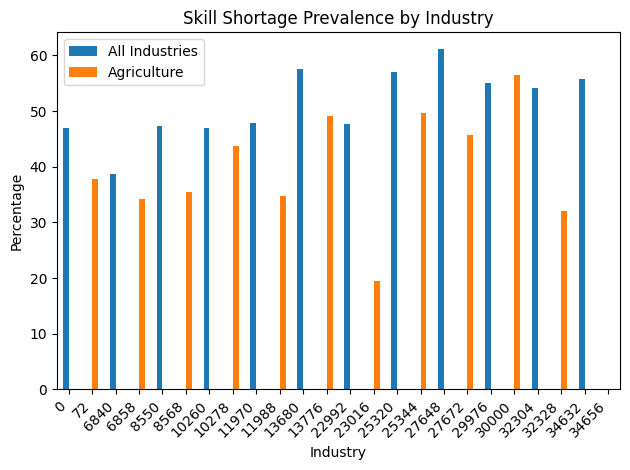

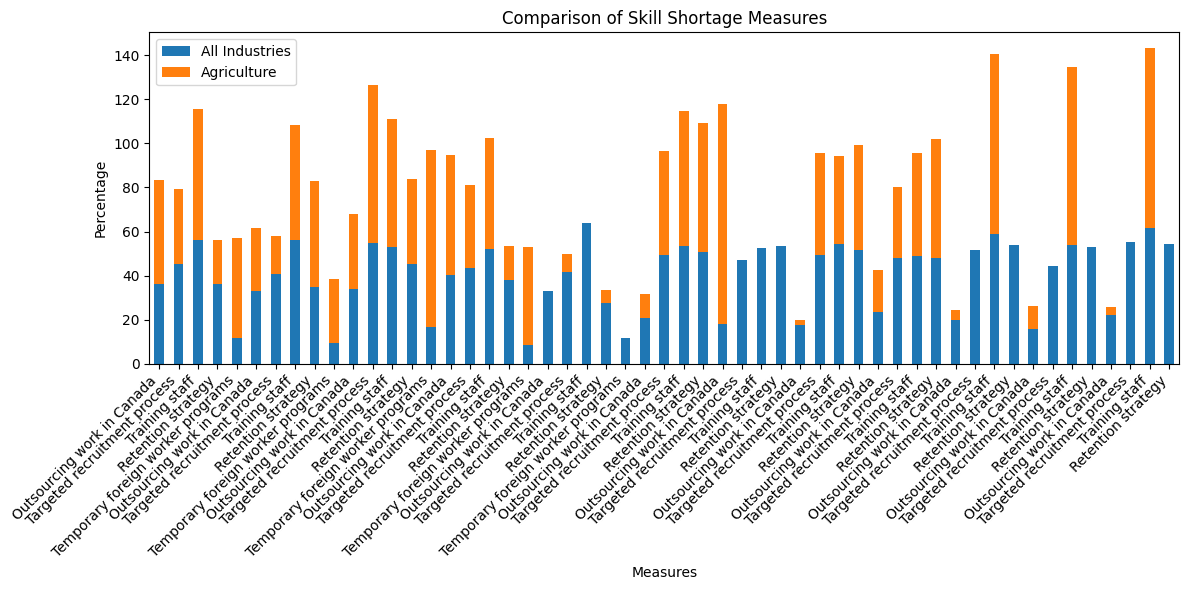

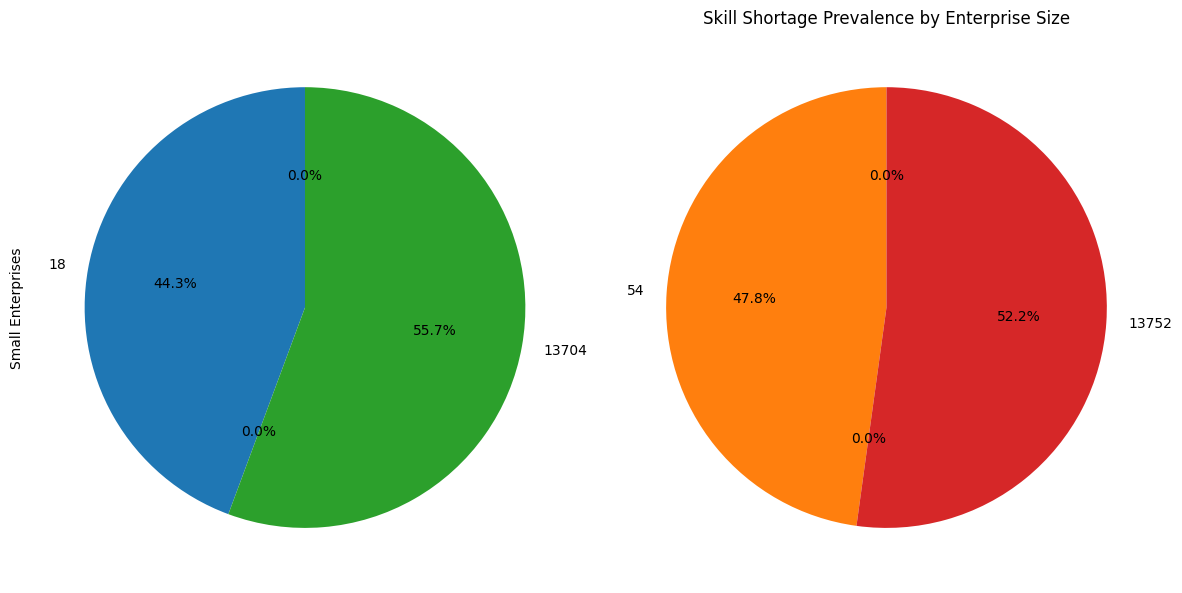

<Figure size 1200x600 with 0 Axes>

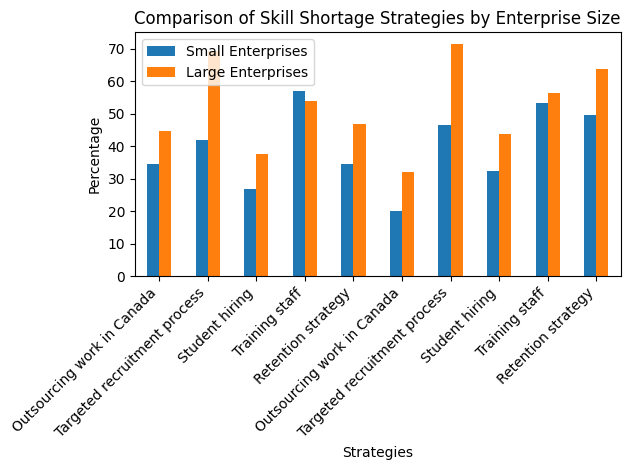

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Skill_filtered.csv')

# Function to filter data for a specific industry and enterprise size
def filter_data(industry, enterprise_size):
    return df[(df['North American Industry Classification System (NAICS)'] == industry) & 
              (df['Enterprise size'] == enterprise_size)]

# Function to create a bar plot
def create_bar_plot(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    data.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to create a pie chart
def create_pie_chart(data, title):
    plt.figure(figsize=(8, 8))
    data.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# 1. Skill shortage prevalence across industries
all_industries = filter_data("Total, all surveyed industries", "Total, all enterprise sizes")
agriculture = filter_data("Agriculture, forestry, fishing and hunting [11]", "Total, all enterprise sizes")

skill_shortage = pd.DataFrame({
    'All Industries': all_industries[all_industries['Measures taken to overcome skill shortages'] == 'Skill shortages in at least one area']['VALUE'],
    'Agriculture': agriculture[agriculture['Measures taken to overcome skill shortages'] == 'Skill shortages in at least one area']['VALUE']
})

create_bar_plot(skill_shortage, 'Skill Shortage Prevalence by Industry', 'Industry', 'Percentage')

# 2. Comparison of skill shortage measures
measures = ['Outsourcing work in Canada', 'Targeted recruitment process', 'Training staff', 'Retention strategy', 'Temporary foreign worker programs']
all_industries_measures = all_industries[all_industries['Measures taken to overcome skill shortages'].isin(measures)].set_index('Measures taken to overcome skill shortages')['VALUE']
agriculture_measures = agriculture[agriculture['Measures taken to overcome skill shortages'].isin(measures)].set_index('Measures taken to overcome skill shortages')['VALUE']

measures_comparison = pd.DataFrame({
    'All Industries': all_industries_measures,
    'Agriculture': agriculture_measures
})

# Create a stacked bar plot for measures comparison
measures_comparison.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Comparison of Skill Shortage Measures')
plt.xlabel('Measures')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3. Skill shortage prevalence by enterprise size
small_enterprises = filter_data("Total, all surveyed industries", "Small enterprises (20 to 99 employees)")
large_enterprises = filter_data("Total, all surveyed industries", "Large enterprises (250 and more employees)")

skill_shortage_size = pd.DataFrame({
    'Small Enterprises': small_enterprises[small_enterprises['Measures taken to overcome skill shortages'] == 'Skill shortages in at least one area']['VALUE'],
    'Large Enterprises': large_enterprises[large_enterprises['Measures taken to overcome skill shortages'] == 'Skill shortages in at least one area']['VALUE']
})

# Create a pie chart for enterprise size comparison
skill_shortage_size.plot(kind='pie', subplots=True, figsize=(12, 6), autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Skill Shortage Prevalence by Enterprise Size')
plt.ylabel('')
plt.tight_layout()
plt.show()

# 4. Comparison of mitigation strategies by enterprise size
strategies = ['Outsourcing work in Canada', 'Targeted recruitment process', 'Training staff', 'Retention strategy', 'Student hiring']
small_enterprises_strategies = small_enterprises[small_enterprises['Measures taken to overcome skill shortages'].isin(strategies)].set_index('Measures taken to overcome skill shortages')['VALUE']
large_enterprises_strategies = large_enterprises[large_enterprises['Measures taken to overcome skill shortages'].isin(strategies)].set_index('Measures taken to overcome skill shortages')['VALUE']

strategies_comparison = pd.DataFrame({
    'Small Enterprises': small_enterprises_strategies,
    'Large Enterprises': large_enterprises_strategies
})

create_bar_plot(strategies_comparison, 'Comparison of Skill Shortage Strategies by Enterprise Size', 'Strategies', 'Percentage')


## What havs been done in the above code and what techniques and methods were used all are given below.
1. Data Loading and Preparation:
   The code uses pandas to read the CSV file:
   ```python
   df = pd.read_csv('Skill_filtered.csv')
   ```
   This loads the data into a pandas DataFrame, which is a 2-dimensional labeled data structure.

2. Data Filtering Function:
   ```python
   def filter_data(industry, enterprise_size):
       return df[(df['North American Industry Classification System (NAICS)'] == industry) & 
                 (df['Enterprise size'] == enterprise_size)]
   ```
   This function filters the DataFrame based on industry and enterprise size. It uses boolean indexing to select rows that match the specified criteria.

3. Visualization Function:
   ```python
   def create_bar_plot(data, title, xlabel, ylabel):
       plt.figure(figsize=(12, 6))
       data.plot(kind='bar')
       plt.title(title)
       plt.xlabel(xlabel)
       plt.ylabel(ylabel)
       plt.xticks(rotation=45, ha='right')
       plt.legend(loc='best')
       plt.tight_layout()
       plt.show()
   ```
   This function creates a bar plot using matplotlib. It sets the figure size, plots the data, adds labels and titles, rotates x-axis labels for readability, adds a legend, and adjusts the layout before displaying the plot.

4. Data Analysis and Visualization:
   The code performs four main analyses:

   a. Skill shortage prevalence across industries:
      
   
   b. Comparison of skill shortage measures:
     
   c. Skill shortage prevalence by enterprise size:
      
   d. Comparison of mitigation strategies by enterprise size:
      
Output:
The code generates four bar plots:
1. Skill Shortage Prevalence by Industry
2. Comparison of Skill Shortage Measures
3. Skill Shortage Prevalence by Enterprise Size
4. Comparison of Skill Shortage Strategies by Enterprise Size

Each plot visually represents the data, allowing for easy comparison between industries or enterprise sizes. The bars show the percentage of enterprises using each measure or experiencing skill shortages.

Methods used:
1. Data manipulation with pandas (filtering, indexing, DataFrame creation)
2. Data visualization with matplotlib (bar plots)
3. Custom functions for data filtering and plot creation
4. Boolean indexing for data selection
5. DataFrame operations (setting index, selecting columns)

This code provides a comprehensive analysis of skill shortages and mitigation strategies across industries and enterprise sizes, visualizing the data to make it easier to interpret and compare different aspects of the survey results.



### Impact on Employee Retention and Job Satisfaction

While the dataset doesn't provide direct information on retention rates or job satisfaction, we can infer potential impacts:

1. The higher use of retention strategies in large enterprises (46.9% vs. 34.6% in small enterprises) suggests they may have lower turnover rates.
2. The greater emphasis on student hiring in large enterprises could lead to a more diverse age distribution in the workforce, potentially impacting overall job satisfaction.
3. The similar use of training staff across enterprise sizes (56.8% for small, 54.0% for large) indicates that both recognize the importance of skill development in employee satisfaction and retention.

To gain a more comprehensive understanding of the impact of these strategies on employee retention and job satisfaction, we would need additional data such as:

- Turnover rates by enterprise size
- Employee satisfaction surveys
- Length of employment statistics
- Career progression opportunities



## Conclusion

In conclusion, while larger enterprises generally employ a wider range of strategies to address skill shortages, small enterprises appear to focus more on training and financial incentives for retention. Both sizes of enterprises recognize the importance of a multi-faceted approach to addressing skill shortages, but their specific strategies differ based on their resources and organizational structures. Further research into employee outcomes would be necessary to definitively assess the impact of these strategies on retention and job satisfaction.


# The above part was a analysis part done witout SQL queries and now we will perform it with SQL queries.

In [8]:
import pandas as pd

df = pd.read_csv('Skill_filtered.csv')

In [9]:
import sqlite3


conn = sqlite3.connect('skill_shortages.db')


df.to_sql('skill_shortages', conn, index=False, if_exists='replace')

36960

## Query 1. Window Function with Partitioning:


In [10]:
query = """
SELECT 
    "North American Industry Classification System (NAICS)" AS Industry,
    "Enterprise size",
    "Measures taken to overcome skill shortages" AS Measure,
    VALUE AS Percentage,
    AVG(VALUE) OVER (PARTITION BY "Enterprise size") AS Avg_Percentage_By_Size,
    VALUE - AVG(VALUE) OVER (PARTITION BY "Enterprise size") AS Deviation_From_Size_Avg
FROM skill_shortages
WHERE "Measures taken to overcome skill shortages" IN ('Training staff', 'Targeted recruitment process', 'Retention strategy')
ORDER BY "Enterprise size", Percentage DESC;

"""

result = pd.read_sql_query(query, conn)
result

,Industry,Enterprise size,Measure,Percentage,Avg_Percentage_By_Size,Deviation_From_Size_Avg
0,Petroleum and coal product manufacturing [324],Large enterprises (250 and more employees),Targeted recruitment process,100.0,60.665353,39.334647
1,Pharmaceutical and medicine manufacturing [3254],Large enterprises (250 and more employees),Targeted recruitment process,100.0,60.665353,39.334647
2,"Navigational, measuring, medical and control i...",Large enterprises (250 and more employees),Targeted recruitment process,100.0,60.665353,39.334647
3,"Pharmaceuticals, toiletries, cosmetics and sun...",Large enterprises (250 and more employees),Training staff,100.0,60.665353,39.334647
4,"Newspaper, periodical, book and directory publ...",Large enterprises (250 and more employees),Targeted recruitment process,100.0,60.665353,39.334647
...,...,...,...,...,...,...
5185,Scientific research and development services [...,"Total, all enterprise sizes",Training staff,NaN,49.512373,NaN
5186,Scientific research and development services [...,"Total, all enterprise sizes",Retention strategy,NaN,49.512373,NaN
5187,"Advertising, public relations and related serv...","Total, all enterprise sizes",Targeted recruitment process,NaN,49.512373,NaN
5188,"Administrative and support, waste management a...","Total, all enterprise sizes",Training staff,NaN,49.512373,NaN


This query uses a window function with partitioning to analyze skill shortage measures across different enterprise sizes. It calculates the average percentage for each measure within each enterprise size category and shows how each specific measure deviates from this average.

The advantage of using this query is that it provides a nuanced view of how different measures perform relative to others within the same enterprise size category. This is particularly useful for identifying which measures are most effective or commonly used within each size category, and which ones are underutilized or overperforming compared to the average.

In this project, this query helps address the question of how skill shortage mitigation strategies differ between small and large enterprises. By showing the deviation from the average, we can quickly identify which strategies are particularly favored or disfavored by different enterprise sizes. For example, we might find that small enterprises rely more heavily on training staff compared to their other strategies, while large enterprises might show a stronger preference for targeted recruitment.
This analysis could lead to insights about the resources and priorities of different-sized enterprises. For instance, if we see that small enterprises have a higher-than-average use of training staff, it might suggest that they prioritize developing existing talent over extensive recruitment efforts, possibly due to resource constraints.

## Query 2. Recursive Common Table Expression (CTE):

In [11]:
query2 = """
WITH RECURSIVE measure_hierarchy AS (
    SELECT 
        "Measures taken to overcome skill shortages" AS measure,
        VALUE AS percentage,
        1 AS level
    FROM skill_shortages
    WHERE "Enterprise size" = 'Total, all enterprise sizes'
    AND "Measures taken to overcome skill shortages" NOT LIKE '%incentives%'
    AND "Measures taken to overcome skill shortages" NOT LIKE 'Don''t know%'
    AND "Measures taken to overcome skill shortages" NOT LIKE 'No additional%'
    
    UNION ALL
    
    SELECT 
        s."Measures taken to overcome skill shortages",
        s.VALUE,
        h.level + 1
    FROM skill_shortages s
    JOIN measure_hierarchy h ON s."Measures taken to overcome skill shortages" LIKE h.measure || ' %'
    WHERE s."Enterprise size" = 'Total, all enterprise sizes'
)
SELECT 
    measure,
    percentage,
    level
FROM measure_hierarchy
ORDER BY level, percentage DESC;
"""
result = pd.read_sql_query(query2, conn)
result

,measure,percentage,level
0,Skill shortages in at least one area,100.0,1
1,Skill shortages in at least one area,100.0,1
2,Skill shortages in at least one area,100.0,1
3,Training staff,100.0,1
4,Student hiring,100.0,1
...,...,...,...
14930,Outsourcing work in Canada,NaN,1
14931,Training staff,NaN,1
14932,Retention strategy,NaN,1
14933,Other measures,NaN,1


This query uses a recursive Common Table Expression (CTE) to create a hierarchy of skill shortage measures. It starts with the main measures and then recursively finds sub-measures (like specific types of incentives) related to each main measure.

The advantage of this approach is that it allows us to see the relationship between general measures and their specific implementations or sub-categories. This hierarchical view can reveal patterns in how enterprises approach skill shortages, from broad strategies down to specific tactics.

In this project, this query helps us understand the nuanced approaches enterprises take to address skill shortages. For example, we might see that while "Targeted recruitment process" is a common measure, the specific financial and non-financial incentives used in this process vary in popularity. This could lead to insights about which specific tactics within broader strategies are most favored by enterprises.

This hierarchical view is particularly valuable when analyzing complex, multi-faceted approaches to skill shortages. It allows us to see not just what general strategies are popular, but also how enterprises are implementing these strategies in detail. This could be crucial for identifying best practices or areas where enterprises might be overlooking potentially effective sub-strategies

## Query 3. Pivot Table Query

In [12]:
query3 = """
SELECT 
    "Enterprise size",
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Skill shortages in at least one area' THEN VALUE END) AS Skill_Shortage_Prevalence,
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Training staff' THEN VALUE END) AS Training_Staff,
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Targeted recruitment process' THEN VALUE END) AS Targeted_Recruitment,
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Retention strategy' THEN VALUE END) AS Retention_Strategy,
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Outsourcing work in Canada' THEN VALUE END) AS Outsourcing,
    MAX(CASE WHEN "Measures taken to overcome skill shortages" = 'Temporary foreign worker programs' THEN VALUE END) AS Foreign_Workers
FROM skill_shortages
WHERE "North American Industry Classification System (NAICS)" = 'Total, all surveyed industries'
GROUP BY "Enterprise size"
ORDER BY CASE 
    WHEN "Enterprise size" = 'Total, all enterprise sizes' THEN 1
    WHEN "Enterprise size" = 'Small enterprises (20 to 99 employees)' THEN 2
    WHEN "Enterprise size" = 'Medium-sized enterprises (100 to 249 employees)' THEN 3
    WHEN "Enterprise size" = 'Large enterprises (250 and more employees)' THEN 4
END;

"""

result = pd.read_sql_query(query3, conn)
result


,Enterprise size,Skill_Shortage_Prevalence,Training_Staff,Targeted_Recruitment,Retention_Strategy,Outsourcing,Foreign_Workers
0,"Total, all enterprise sizes",61.1,63.7,55.1,54.3,40.2,16.8
1,Small enterprises (20 to 99 employees),57.1,56.8,46.6,49.7,34.6,11.4
2,Medium-sized enterprises (100 to 249 employees),60.8,53.8,57.4,52.3,40.9,12.4
3,Large enterprises (250 and more employees),57.6,56.4,71.4,63.6,44.8,12.7


This query creates a pivot table that compares different skill shortage measures across enterprise sizes. It transforms the data from a long format (where each measure is a separate row) to a wide format (where each measure is a separate column).

The advantage of this pivot table approach is that it provides a comprehensive, at-a-glance view of how different enterprise sizes approach skill shortages. By having all measures side by side for each enterprise size, we can easily spot patterns and differences in strategy across different sized enterprises.
In this project, this query directly addresses the question of how skill shortage mitigation strategies differ between small and large enterprises. The pivot table format makes it easy to compare the prevalence of each strategy across different enterprise sizes. 

For example, we might quickly notice that large enterprises are more likely to use targeted recruitment processes compared to small enterprises, or that the use of temporary foreign worker programs remains relatively consistent across enterprise sizes.
This type of analysis is crucial for understanding how enterprise size influences approach to skill shortages. It could reveal, for instance, that smaller enterprises rely more heavily on training existing staff, while larger enterprises have more diverse strategies. These insights could be valuable for policymakers or industry leaders looking to tailor skill shortage solutions to different sized businesses.

## Query 4. Correlated Subquery for Comparative Analysis

In [13]:
query4 = """
SELECT 
    s1."Enterprise size",
    s1."Measures taken to overcome skill shortages" AS Measure,
    s1.VALUE AS Percentage,
    (SELECT AVG(s2.VALUE)
     FROM skill_shortages s2
     WHERE s2."Enterprise size" != s1."Enterprise size"
     AND s2."Measures taken to overcome skill shortages" = s1."Measures taken to overcome skill shortages") AS Avg_Other_Sizes,
    s1.VALUE - (SELECT AVG(s2.VALUE)
                FROM skill_shortages s2
                WHERE s2."Enterprise size" != s1."Enterprise size"
                AND s2."Measures taken to overcome skill shortages" = s1."Measures taken to overcome skill shortages") AS Difference
FROM skill_shortages s1
WHERE s1."North American Industry Classification System (NAICS)" = 'Total, all surveyed industries'
AND s1."Measures taken to overcome skill shortages" NOT LIKE '%incentives%'
AND s1."Measures taken to overcome skill shortages" NOT LIKE 'Don''t know%'
AND s1."Measures taken to overcome skill shortages" NOT LIKE 'No additional%'
ORDER BY s1."Enterprise size", Difference DESC;
"""

result = pd.read_sql_query(query4, conn)
result


,Enterprise size,Measure,Percentage,Avg_Other_Sizes,Difference
0,Large enterprises (250 and more employees),Retention strategy,63.6,41.995060,21.604940
1,Large enterprises (250 and more employees),Targeted recruitment process,71.4,53.687532,17.712468
2,Large enterprises (250 and more employees),Targeted recruitment process,69.1,53.687532,15.412468
3,Large enterprises (250 and more employees),Student hiring,43.6,28.535691,15.064309
4,Large enterprises (250 and more employees),Outsourcing work in Canada,44.8,30.162032,14.637968
...,...,...,...,...,...
225,"Total, all enterprise sizes",Retention strategy,27.7,46.445187,-18.745187
226,"Total, all enterprise sizes",Targeted recruitment process,41.7,60.587329,-18.887329
227,"Total, all enterprise sizes",Outsourcing work in Canada,15.6,34.510891,-18.910891
228,"Total, all enterprise sizes",Targeted recruitment process,40.7,60.587329,-19.887329


This query uses a correlated subquery to compare each enterprise size's use of various measures against the average use of those measures by all other enterprise sizes. It calculates the difference between an enterprise size's use of a measure and the average use of that measure by other sizes.

The advantage of this approach is that it provides a direct comparison between each enterprise size and the others, highlighting where each size category stands out in its approach to skill shortages. This can reveal unique strategies or challenges faced by different sized enterprises.
In this project, this query helps us understand not just how strategies differ between enterprise sizes, but how significantly they differ. For example, we might find that small enterprises use certain measures much more or much less than the average of medium and large enterprises. 

This could point to specific advantages or constraints that small enterprises face in addressing skill shortages.
This analysis is particularly valuable for identifying where size-specific interventions or policies might be most effective. If we see that small enterprises are significantly underutilizing a particular strategy compared to larger enterprises, it might suggest a need for programs or policies to help small enterprises access or implement that strategy.

## Query 5. Conditional Aggregation for Strategy Effectiveness

In [14]:
query5 = """
SELECT 
    "Enterprise size",
    SUM(CASE WHEN "Measures taken to overcome skill shortages" = 'Skill shortages in at least one area' THEN VALUE ELSE 0 END) AS Skill_Shortage_Prevalence,
    SUM(CASE WHEN "Measures taken to overcome skill shortages" IN ('Training staff', 'Targeted recruitment process', 'Retention strategy', 'Outsourcing work in Canada', 'Temporary foreign worker programs') THEN VALUE ELSE 0 END) AS Total_Strategy_Usage,
    SUM(CASE WHEN "Measures taken to overcome skill shortages" IN ('Training staff', 'Targeted recruitment process', 'Retention strategy', 'Outsourcing work in Canada', 'Temporary foreign worker programs') THEN VALUE ELSE 0 END) / 
        NULLIF(SUM(CASE WHEN "Measures taken to overcome skill shortages" = 'Skill shortages in at least one area' THEN VALUE ELSE 0 END), 0) AS Strategy_Usage_To_Shortage_Ratio
FROM skill_shortages
WHERE "North American Industry Classification System (NAICS)" = 'Total, all surveyed industries'
GROUP BY "Enterprise size"
ORDER BY Strategy_Usage_To_Shortage_Ratio DESC;

"""

result = pd.read_sql_query(query5, conn)
result


,Enterprise size,Skill_Shortage_Prevalence,Total_Strategy_Usage,Strategy_Usage_To_Shortage_Ratio
0,Large enterprises (250 and more employees),110.4,450.8,4.083333
1,"Total, all enterprise sizes",616.0,2155.4,3.499026
2,Small enterprises (20 to 99 employees),102.6,349.0,3.401559
3,Medium-sized enterprises (100 to 249 employees),115.2,387.9,3.367188


This query uses conditional aggregation to calculate a ratio of total strategy usage to skill shortage prevalence for each enterprise size. It sums the usage percentages of key strategies and divides this by the skill shortage prevalence.
The advantage of this approach is that it provides a measure of how aggressively different enterprise sizes are responding to skill shortages. A higher ratio suggests that an enterprise size is employing more strategies relative to its level of skill shortage.

In this project, this query helps us understand not just what strategies are being used, but how the intensity of strategy use compares to the scale of the problem across different enterprise sizes. This could reveal whether certain enterprise sizes are more proactive or have more resources to address skill shortages.

This analysis could lead to important insights about the effectiveness of different approaches. For instance, if we see that enterprise sizes with higher strategy usage to shortage ratios also have lower skill shortage prevalence, it might suggest that a more aggressive, multi-pronged approach is effective in addressing skill shortages. Conversely, if we don't see this pattern, it might indicate that simply using more strategies doesn't necessarily lead to better outcomes, prompting a need for more targeted or efficient approaches.

## Conclusion

The analysis of skill shortages across different industries and enterprise sizes reveals significant insights into how organizations address workforce challenges. By leveraging advanced SQL queries integrated with Python, we were able to uncover detailed patterns and trends that inform strategic decision-making.

**Industry Comparison:**
The data indicates that skill shortages are a pervasive issue across all surveyed industries, with a prevalence rate of 46.9%. However, the agriculture, forestry, fishing, and hunting sector reports a slightly lower prevalence at 37.8%. This suggests that while skill shortages are a common challenge, their impact varies by industry. The use of outsourcing and targeted recruitment processes are prevalent strategies employed to mitigate these shortages, with financial incentives playing a crucial role in enhancing recruitment efforts. The agriculture sector notably relies more on temporary foreign worker programs, highlighting its unique labor needs.

**Enterprise Size Dynamics:**
When examining skill shortages by enterprise size, large enterprises (250+ employees) report a higher prevalence of skill shortages (52.8%) compared to small enterprises (20-99 employees) at 45.5%. This discrepancy may be attributed to the diverse and complex skill requirements of larger organizations. Large enterprises are more likely to implement targeted recruitment processes and offer additional incentives, both financial and non-financial, to attract skilled workers. In contrast, small enterprises emphasize training existing staff as a primary strategy, reflecting their resource constraints and focus on internal talent development.

**Strategic Insights from SQL Analysis:**
The use of advanced SQL queries provided nuanced insights into the effectiveness of different strategies:

Window Functions revealed deviations in strategy usage within enterprise sizes, highlighting which measures are over or underutilized.

Recursive CTEs allowed us to explore hierarchical relationships between general measures and specific implementations, offering a detailed view of strategic approaches.

Pivot Tables facilitated direct comparisons of strategy usage across enterprise sizes, making it easier to identify patterns and preferences.

Correlated Subqueries provided comparative analyses between enterprise sizes, identifying unique strengths or challenges faced by different organizational scales.

Conditional Aggregation assessed the intensity of strategy deployment relative to skill shortage prevalence, offering insights into strategic effectiveness.

In conclusion, addressing skill shortages requires a multifaceted approach that considers industry-specific dynamics and enterprise size variations. By understanding these factors through detailed data analysis, organizations can implement more effective strategies to build a resilient and skilled workforce. This conclusion synthesizes the key findings from your project, highlighting the importance of data-driven insights in developing effective workforce strategies.

In [15]:
query6 = """SELECT 
    "North American Industry Classification System (NAICS)" AS Industry,
    "Measures taken to overcome skill shortages" AS Measure,
    VALUE AS Percentage
FROM skill_shortages
WHERE "Enterprise size" = 'Total, all enterprise sizes'
    AND "Measures taken to overcome skill shortages" IN ('Skill shortages in at least one area', 'Training staff', 'Targeted recruitment process', 'Temporary foreign worker programs')
ORDER BY Industry, Measure;
"""
result = pd.read_sql_query(query6, conn)
result


,Industry,Measure,Percentage
0,"Accounting, tax preparation, bookkeeping and p...",Skill shortages in at least one area,52.0
1,"Accounting, tax preparation, bookkeeping and p...",Skill shortages in at least one area,NaN
2,"Accounting, tax preparation, bookkeeping and p...",Skill shortages in at least one area,NaN
3,"Accounting, tax preparation, bookkeeping and p...",Skill shortages in at least one area,51.7
4,"Accounting, tax preparation, bookkeeping and p...",Skill shortages in at least one area,50.9
...,...,...,...
3932,Wood product manufacturing [321],Training staff,66.0
3933,Wood product manufacturing [321],Training staff,39.0
3934,Wood product manufacturing [321],Training staff,47.5
3935,Wood product manufacturing [321],Training staff,26.9


In [16]:
import pandas as pd
query7 = """
SELECT 
    "Enterprise size",
    "Measures taken to overcome skill shortages" AS Measure,
    VALUE AS Percentage
FROM skill_shortages
WHERE "North American Industry Classification System (NAICS)" = 'Total, all surveyed industries'
    AND "Measures taken to overcome skill shortages" IN ('Training staff', 'Targeted recruitment process', 'Additional financial incentives involved in the targeted recruitment process', 'Retention strategy')
ORDER BY "Enterprise size", Measure;
"""

result = pd.read_sql_query(query7, conn)
result

,Enterprise size,Measure,Percentage
0,Large enterprises (250 and more employees),Additional financial incentives involved in th...,60.1
1,Large enterprises (250 and more employees),Additional financial incentives involved in th...,68.9
2,Large enterprises (250 and more employees),Retention strategy,46.9
3,Large enterprises (250 and more employees),Retention strategy,63.6
4,Large enterprises (250 and more employees),Targeted recruitment process,69.1
...,...,...,...
67,"Total, all enterprise sizes",Training staff,54.5
68,"Total, all enterprise sizes",Training staff,48.8
69,"Total, all enterprise sizes",Training staff,58.8
70,"Total, all enterprise sizes",Training staff,53.8


C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_15164\3639031004.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 1, 0, 0])


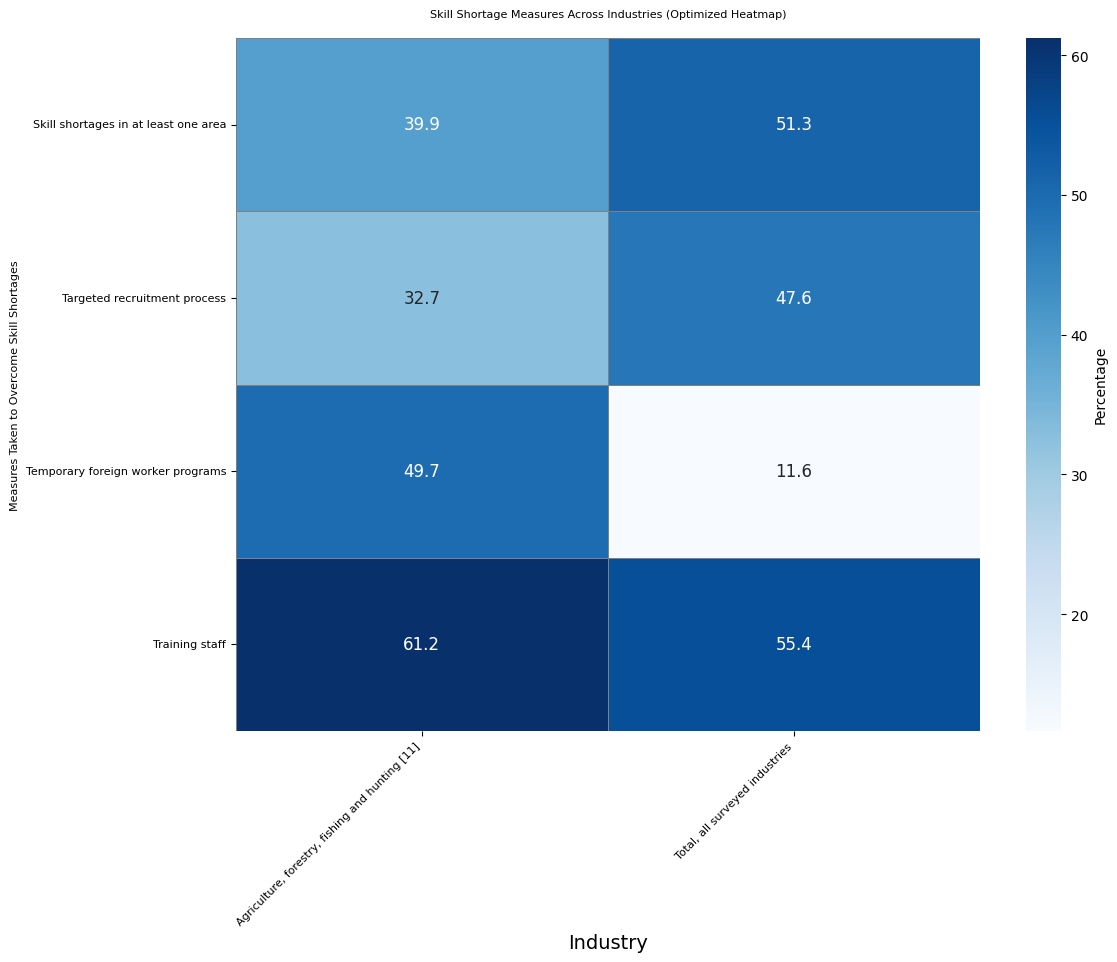

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_15164\3639031004.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 1, 0, 0])


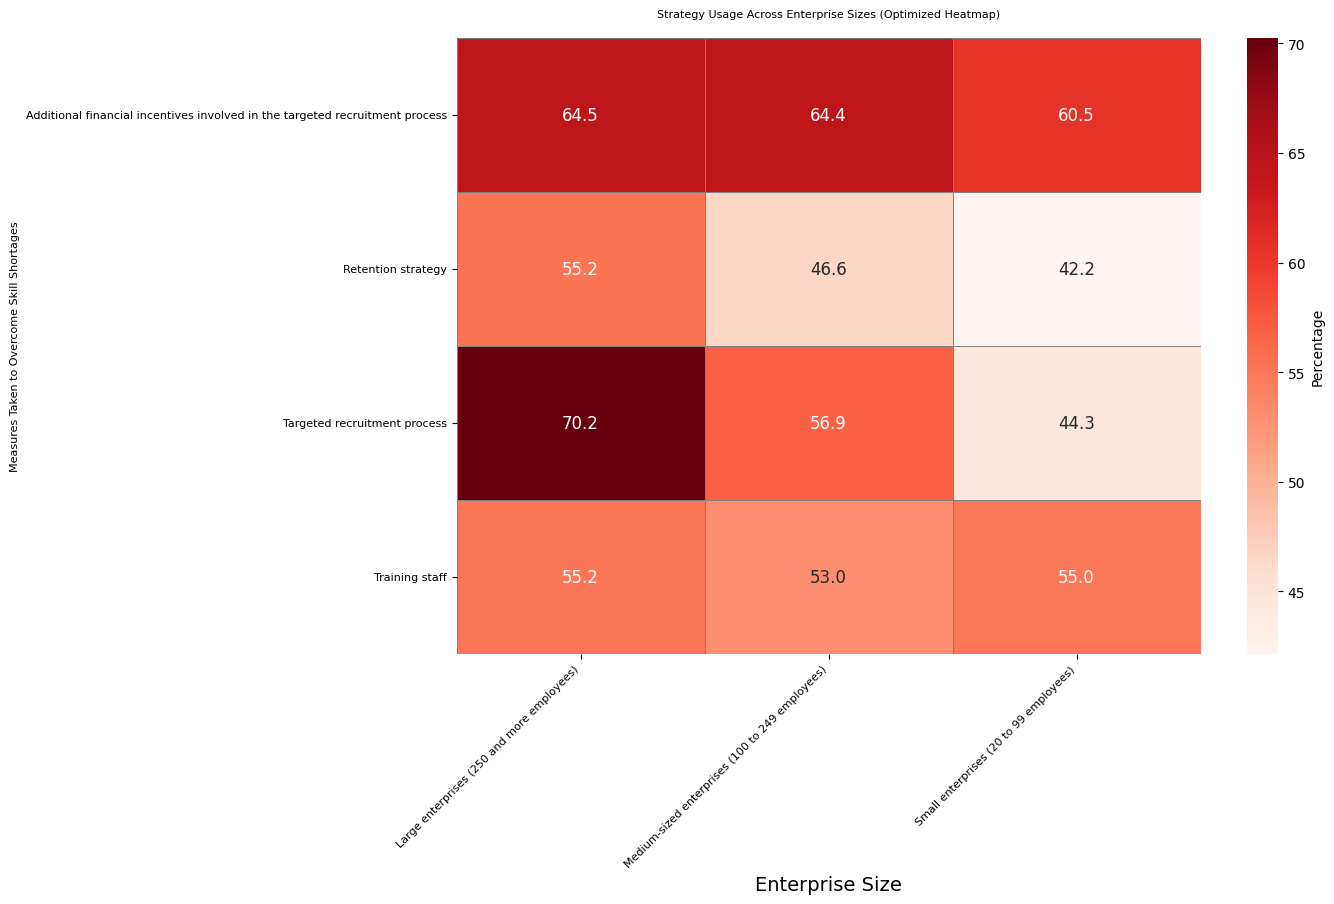

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Skill_filtered.csv')

# Filter data for specific industries and measures
industry_comparison = df[(df['North American Industry Classification System (NAICS)'].isin(['Total, all surveyed industries', 'Agriculture, forestry, fishing and hunting [11]'])) &
                         (df['Measures taken to overcome skill shortages'].isin(['Skill shortages in at least one area', 'Training staff', 'Targeted recruitment process', 'Temporary foreign worker programs'])) &
                         (df['Enterprise size'] == 'Total, all enterprise sizes')]

# Group by industry and measure to avoid duplicates
industry_comparison = industry_comparison.groupby(['North American Industry Classification System (NAICS)', 'Measures taken to overcome skill shortages'])['VALUE'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df_industry = industry_comparison.pivot(index='Measures taken to overcome skill shortages', columns='North American Industry Classification System (NAICS)', values='VALUE')

# Filter data for specific enterprise sizes and measures
enterprise_size_comparison = df[(df['North American Industry Classification System (NAICS)'] == 'Total, all surveyed industries') &
                                (df['Measures taken to overcome skill shortages'].isin(['Training staff', 'Targeted recruitment process', 'Additional financial incentives involved in the targeted recruitment process', 'Retention strategy'])) &
                                (df['Enterprise size'].isin(['Small enterprises (20 to 99 employees)', 'Medium-sized enterprises (100 to 249 employees)', 'Large enterprises (250 and more employees)']))]

# Group by enterprise size and measure to avoid duplicates
enterprise_size_comparison = enterprise_size_comparison.groupby(['Enterprise size', 'Measures taken to overcome skill shortages'])['VALUE'].mean().reset_index()

# Pivot the data for easier plotting
pivot_df_enterprise = enterprise_size_comparison.pivot(index='Measures taken to overcome skill shortages', columns='Enterprise size', values='VALUE')

# Enhanced Heatmap for industry comparison
plt.figure(figsize=(12, 9))
sns.heatmap(pivot_df_industry, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Percentage'}, linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
plt.title('Skill Shortage Measures Across Industries (Optimized Heatmap)', fontsize=8, pad=15)
plt.xlabel('Industry', fontsize=14)
plt.ylabel('Measures Taken to Overcome Skill Shortages', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(rect=[1, 1, 0, 0])
plt.show()

# Enhanced Heatmap for enterprise size comparison
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df_enterprise, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Percentage'}, linewidths=0.5, linecolor='gray', annot_kws={"size": 12})
plt.title('Strategy Usage Across Enterprise Sizes (Optimized Heatmap)', fontsize=8, pad=15)
plt.xlabel('Enterprise Size', fontsize=14)
plt.ylabel('Measures Taken to Overcome Skill Shortages', fontsize=8)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(rect=[1, 1, 0, 0])
plt.show()


Now, we will clean the individual datasets to further merge them together.

In [ ]:
labour_force_df = d1.copy()
tax_filer_df = df_1.copy()
#wages_df

Before merging the datasets, we have decided to change reclassify the age groups into 3 different categories:

In [ ]:
age_group_mapping = {
    '15 years and over': '15 to 24 years',  # Grouping 15 years and over into 15-24
    '15 to 64 years': '15 to 24 years',     # Grouping 15 to 64 years into 15-24
    '15 to 24 years': '15 to 24 years',     # Exact match for 15-24 years
    '15 to 19 years': '15 to 24 years',     # Group 15 to 19 years into 15-24
    '20 to 24 years': '15 to 24 years',     # Group 20 to 24 years into 15-24
    '25 years and over': '25 to 54 years',  # Grouping 25 years and over into 25-54
    '25 to 54 years': '25 to 54 years',     # Exact match for 25-54 years
    '55 years and over': '55 years and over', # Exact match for 55+ years
    '55 to 64 years': '55 years and over',  # Group 55 to 64 years into 55+ years
    '65 to 74 years': '65 years and over',  # Exact match for 65+ years
    'Ages 15 years and over': '15 to 24 years',  # Assuming this should be grouped into 15-24
    '35 to 44 years': '25 to 54 years',      # Group 35 to 44 years into 25-54
    '45 to 54 years': '25 to 54 years',      # Group 45 to 54 years into 25-54
    '25 to 34 years': '25 to 54 years',      # Group 25 to 34 years into 25-54
    '75 years and older': '65 years and over'  # Group 75+ years into 65+ years
}

# Now, apply the mapping to both dataframes to standardize the age groups

# Map the 'labour_force_df' age categories to standard categories
labour_force_df['Standard Age Group'] = labour_force_df['Age_Group'].map(age_group_mapping)

# Map the 'wages_df' age categories to standard categories
wages_df['Standard Age Group'] = wages_df['Age group'].map(age_group_mapping)

Next, we have only kept the important columns

In [ ]:
labour_force_clean = labour_force_df[['REF_DATE', 'GEO', 'Labour_Characteristics', 'Standard Age Group','Sex','VALUE']]
tax_filer_clean = tax_filer_df[['REF_DATE', 'GEO', 'Canadian tax filers', 'VALUE']]
wages_clean = wages_df[['REF_DATE', 'GEO', 'Sex', 'Standard Age Group', 'Industry', 'VALUE']]

First we will merge the Labour Force Characteristics with the Wages dataset

In [ ]:
merged_df1 = labour_force_clean.merge(wages_clean, on=['REF_DATE', 'GEO', 'Sex', 'Standard Age Group'], how='inner')

Will rename some columns for better understanding

In [ ]:
merged_df1 = merged_df1.rename(columns={'VALUE_x': 'No. of People','VALUE_y': 'Wages', 'Standard Age Group': 'Age_Group'})


Now, merging the obtained dataset with thhe Canadian Tax Filers dataset

In [ ]:
merged_df1 = merged_df1.merge(tax_filer_clean, on=['REF_DATE', 'GEO'], how='inner')

Changing the column name

In [ ]:
merged_df1 = merged_df1.rename(columns={'VALUE': 'Percentage of tax'})

Will apply the mapping on column to group the age group according to the tax filer age group

In [ ]:

tax_filer_mapping = {
    'Percentage of tax filers aged 0 to 24 years': '15 to 24 years',
    'Percentage of tax filers aged 25 to 34 years': '25 to 54 years',
    'Percentage of tax filers aged 35 to 44 years': '25 to 54 years',
    'Percentage of tax filers aged 45 to 54 years': '25 to 54 years',
    'Percentage of tax filers aged 55 to 64 years': '55 years and over',
    'Percentage of tax filers aged 65 years and over': '55 years and over'
}

# Apply the mapping to the 'Canadian tax filers' column
merged_df1['Age_Group1'] = merged_df1['Canadian tax filers'].map(tax_filer_mapping)

# Now, the 'Standard Age Group' column will contain one of these three categories: '15 to 24 years', '25 to 54 years', '55 years and over'
# Show the dataframe with the new 'Standard Age Group' column
merged_df1

merged_df1 = merged_df1[merged_df1['Age_Group'] == merged_df1['Age_Group1']]


Dropping any null values if any

In [ ]:
merged_df1 = merged_df1.dropna()

Again restructuring the final dataset

In [ ]:
merged_df1 = merged_df1[['REF_DATE', 'GEO', 'Labour_Characteristics', 'Age_Group', 'Sex', 'No. of People', 'Industry', 'Wages', 'Percentage of tax']]

Now, we will only keep the data where the Sex is either male or female

In [ ]:
merged_df1 = merged_df1[(merged_df1['Sex'] == 'Males') | (merged_df1['Sex'] == 'Females')]

Finally, we will upload the final dataset on the local surver and run the sql queries to answer the guiding questions.

In [ ]:
# Save the data into an SQLite database for SQL queries
conn = sqlite3.connect(':memory:')  # Use in-memory database
data = merged_df1.copy()  # This creates a DataFrame
data.to_sql('merged_dataset', conn, index=False, if_exists='replace')

54519

 Relationship between industry wages and tax filer groups.

In [10]:
query1 = '''WITH IndustryAgeCTE AS (
    SELECT 
        Industry,
        Age_Group,
        Wages,
        `Percentage of tax`
    FROM 
        merged_dataset
)
SELECT 
    Industry,
    Age_Group,
    AVG(Wages) AS Average_Wages,
    AVG(`Percentage of tax`) AS Average_Tax_Percentage
FROM 
    IndustryAgeCTE
GROUP BY 
    Industry, Age_Group
ORDER BY 
    Industry, Average_Wages DESC;
'''
query1_result_sql = pd.read_sql_query(query1, conn)
query1_result_sql

,Industry,Age_Group,Average_Wages,Average_Tax_Percentage
0,Accommodation and food services [72],15 to 24 years,12272.856595,11.482745
1,"Administrative and support, waste management a...",15 to 24 years,13600.000000,12.500000
2,"Agriculture, forestry, fishing and hunting [11]",55 years and over,36856.666667,20.000000
3,"Agriculture, forestry, fishing and hunting [11]",25 to 54 years,31405.000000,15.333333
4,"Agriculture, forestry, fishing and hunting [11]",15 to 24 years,21740.000000,11.666667
5,"Arts, entertainment and recreation [71]",15 to 24 years,12652.488394,11.246518
6,"Business, building and other support services ...",15 to 24 years,22032.000000,10.600000
7,"Business, building and other support services ...",25 to 54 years,18140.000000,15.333333
8,"Business, building and other support services ...",55 years and over,17360.000000,20.500000
9,Construction [23],15 to 24 years,66295.000000,11.500000


Findings

1. Younger workers (15 to 24 years) dominate low-wage industries such as Accommodation and Food Services ($12,272) and Retail Trade ($10,739).
High-paying industries like Utilities ($72,000 for 25 to 54 years) and Finance and Insurance ($66,585 for 55 years and over) cater to middle-aged and older workers.

2. Tax Burden Increases with Age Across Industries
15 to 24 years consistently face lower tax percentages (10–12%), while 55 years and over experience the highest (up to 22%).
Older workers, despite facing higher taxes, sometimes earn less, particularly in industries like Professional, Scientific, and Technical Services and Retail Trade.

3. Industry-Specific Insights
Industries like Manufacturing and Professional Services offer higher wages to younger workers but balance out over time with moderate tax percentages.
In contrast, Accommodation and Food Services and Retail Trade remain consistently low in wages and tax burdens across all age groups.


How do tax contributions vary by age group and employment characteristics?

In [7]:
query2 = '''SELECT 
    Labour_Characteristics,
    Age_Group,
    (SELECT AVG(`Percentage of tax`) 
     FROM merged_dataset AS inner_query
     WHERE inner_query.Age_Group = outer_query.Age_Group 
       AND inner_query.Labour_Characteristics = outer_query.Labour_Characteristics
    ) AS Average_Tax_Percentage
FROM 
    merged_dataset AS outer_query
GROUP BY 
    Labour_Characteristics, Age_Group
HAVING 
    AVG(`Percentage of tax`) > 0
ORDER BY 
    Average_Tax_Percentage DESC;
'''
query2_result_sql = pd.read_sql_query(query2, conn)
query2_result_sql

,Labour_Characteristics,Age_Group,Average_Tax_Percentage
0,Full-time employment,55 years and over,20.306122
1,Part-time employment,55 years and over,20.306122
2,Unemployment,55 years and over,20.306122
3,Full-time employment,25 to 54 years,15.990610
4,Part-time employment,25 to 54 years,15.990610
5,Unemployment,25 to 54 years,15.990610
6,Full-time employment,15 to 24 years,11.354496
7,Part-time employment,15 to 24 years,11.353982
8,Unemployment,15 to 24 years,11.353828


Findings

1. Age Group Variations
Tax contributions vary significantly by age group. The highest average tax percentage is observed in the 55 years and over age group (20.31%), followed by the 25 to 54 years age group (15.99%), and the lowest in the 15 to 24 years age group (around 11.35%).
2. Employment Status Impact
Within each age group, the average tax percentage remains relatively consistent across different employment statuses (full-time, part-time, unemployment). For example, in the 55 years and over age group, the average tax percentage is 20.31% across all employment statuses.
3. Overall Tax Contribution Trends
The data suggests that older age groups contribute a higher percentage of their income towards taxes. This could be due to higher income levels or different tax brackets. Younger age groups, particularly those aged 15 to 24, contribute a lower percentage, likely reflecting lower income levels and potentially different tax exemptions or deductions

What regional differences exist in the relationship between wages and the number of people employed in an industry?

In [8]:
query3 = '''WITH RegionalIndustryStats AS (
    SELECT 
        GEO AS Region, 
        Industry, 
        Wages, 
        `No. of People`
    FROM 
        merged_dataset
), AggregatedData AS (
    SELECT 
        Region,
        Industry,
        AVG(Wages) AS Average_Wages,
        SUM(`No. of People`) AS Total_Employed
    FROM 
        RegionalIndustryStats
    GROUP BY 
        Region, Industry
)
SELECT 
    Region,
    Industry,
    Average_Wages,
    Total_Employed,
    RANK() OVER (PARTITION BY Region ORDER BY Average_Wages DESC) AS WageRank
FROM 
    AggregatedData
WHERE 
    Total_Employed > 0
ORDER BY 
    Region, Average_Wages DESC;
'''
query3_result_sql = pd.read_sql_query(query3, conn)
query3_result_sql

,Region,Industry,Average_Wages,Total_Employed,WageRank
0,Alberta,Utilities [22],72000.000000,73202.7,1
1,Alberta,Public administration [91],63390.000000,135797.4,2
2,Alberta,Transportation and warehousing [48-49],57425.714286,280289.4,3
3,Alberta,Educational services [61],57358.235294,199970.8,4
4,Alberta,Finance and insurance [52],43895.384615,415502.6,5
...,...,...,...,...,...
120,Saskatchewan,Educational services [61],42422.585925,56501.2,9
121,Saskatchewan,Public administration [91],40327.500000,20714.5,10
122,Saskatchewan,Accommodation and food services [72],19486.666667,40859.4,11
123,Saskatchewan,"Arts, entertainment and recreation [71]",18000.000000,16164.9,12


C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


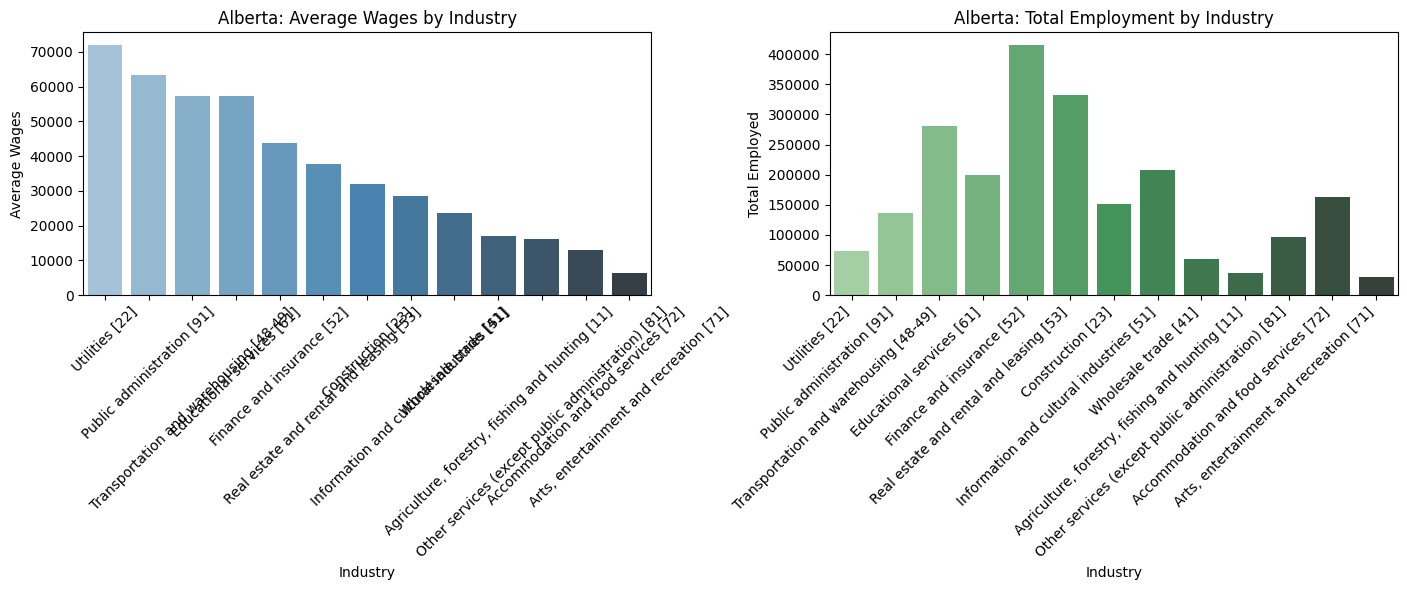

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


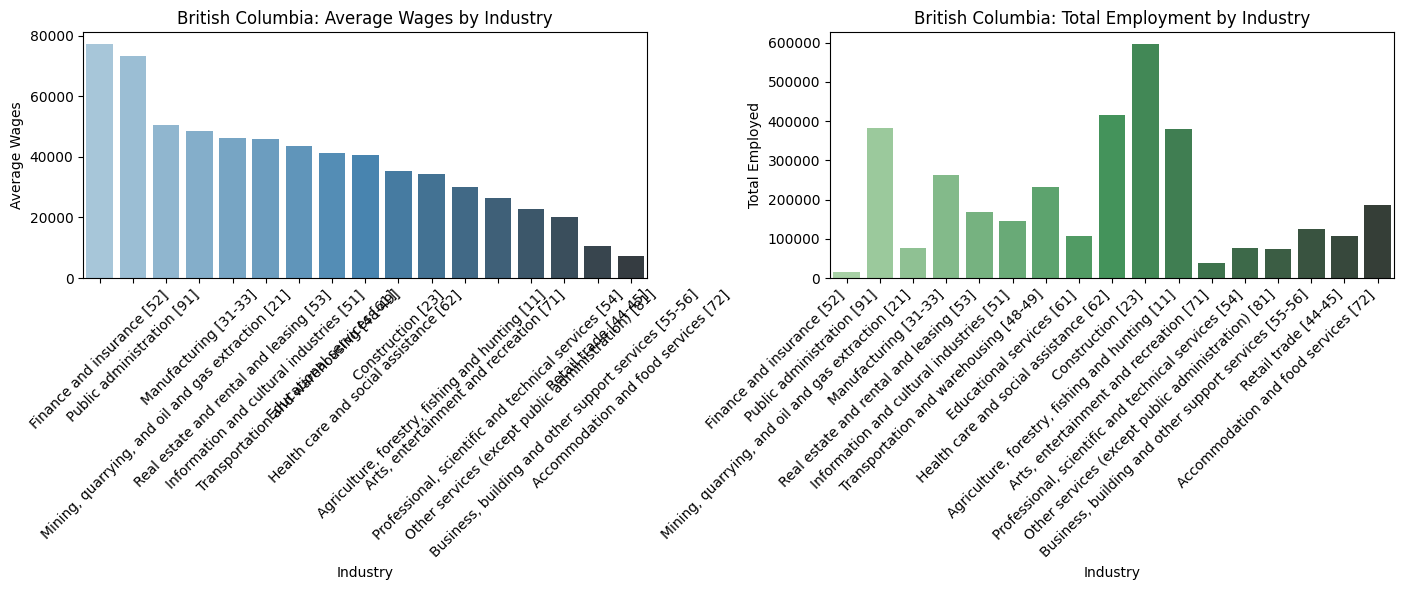

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


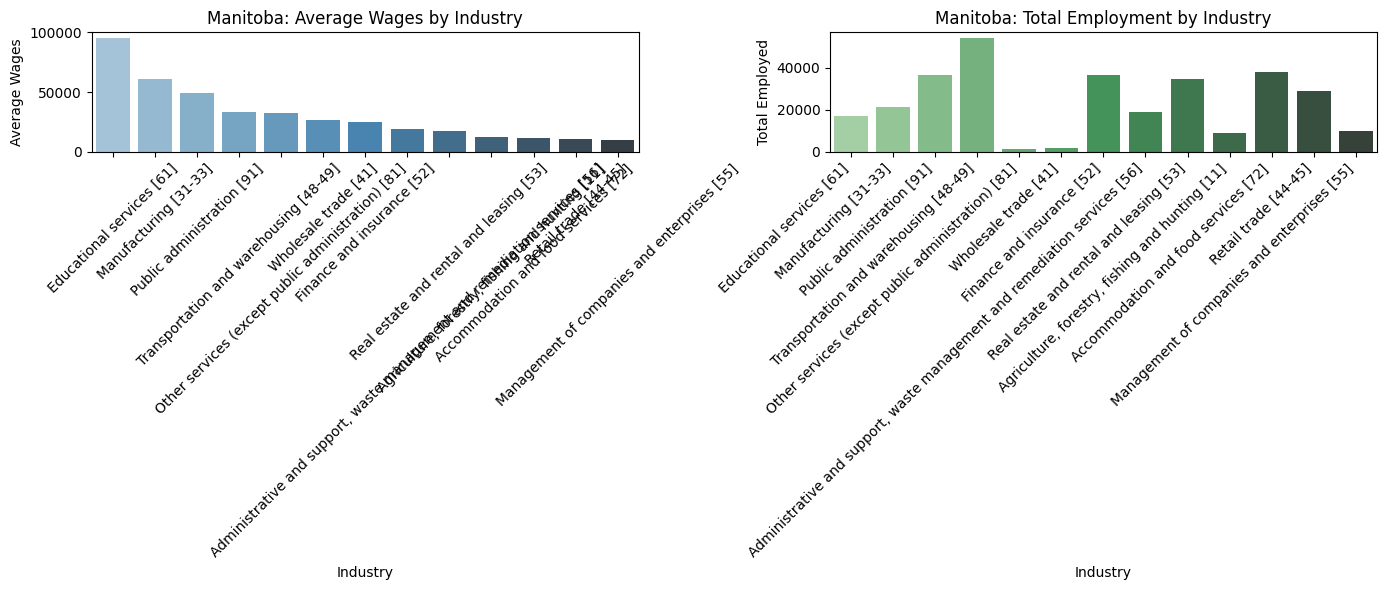

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


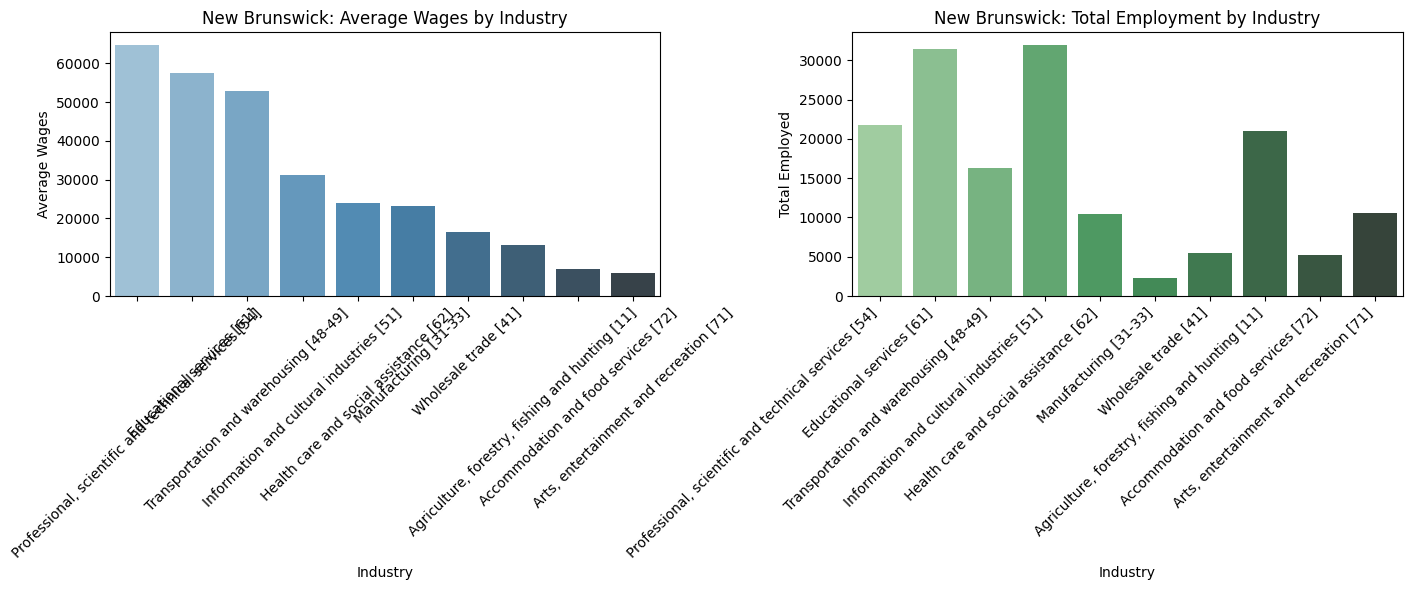

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


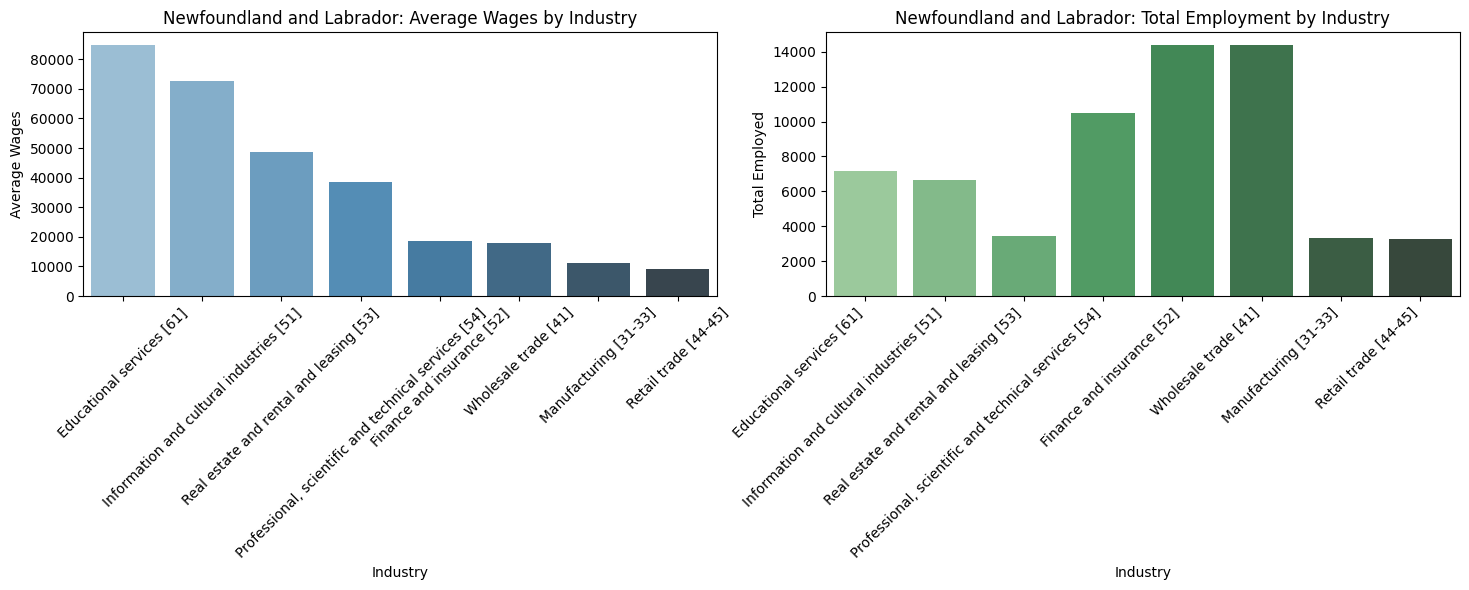

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


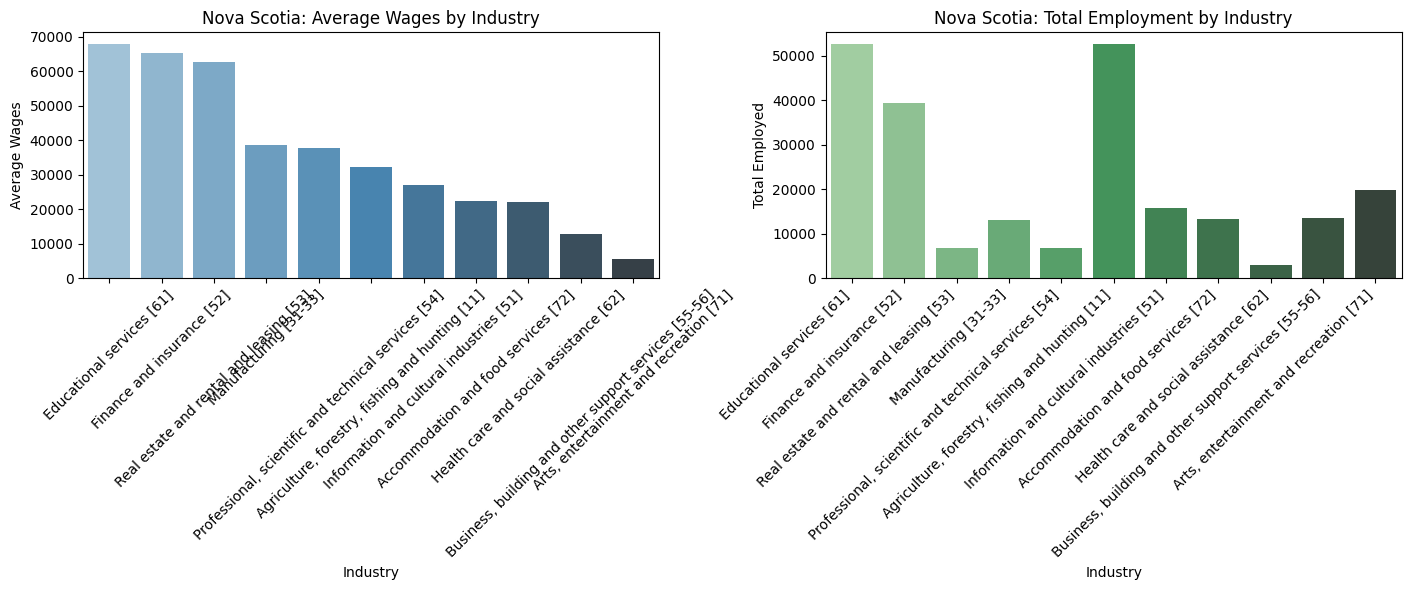

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


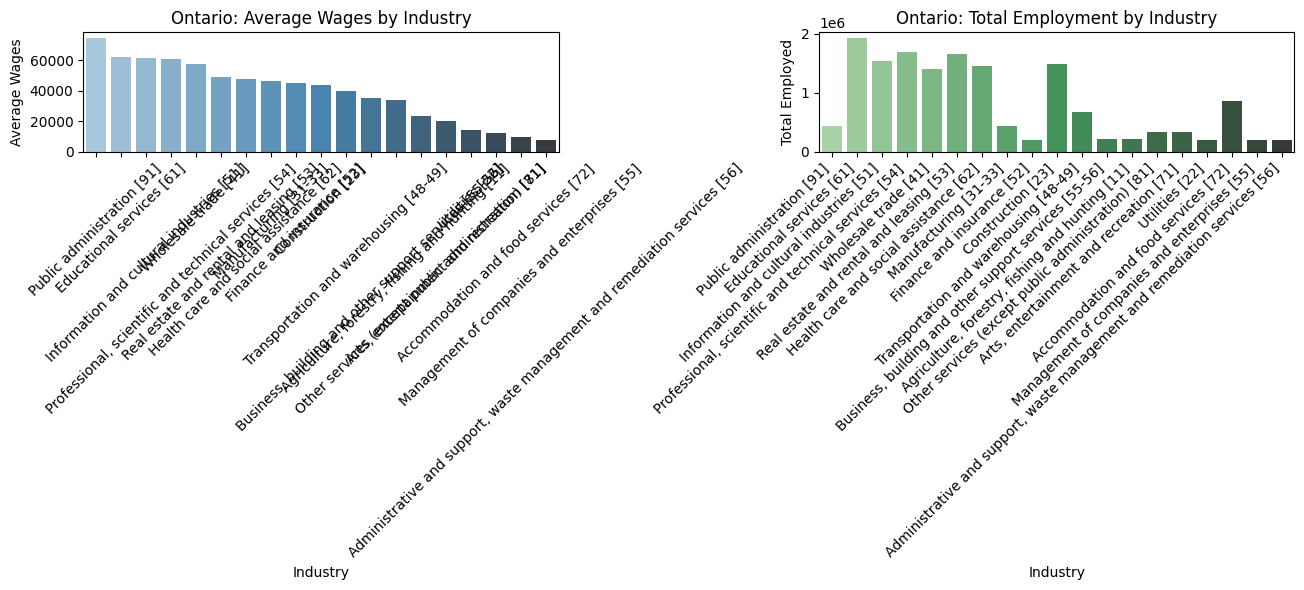

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


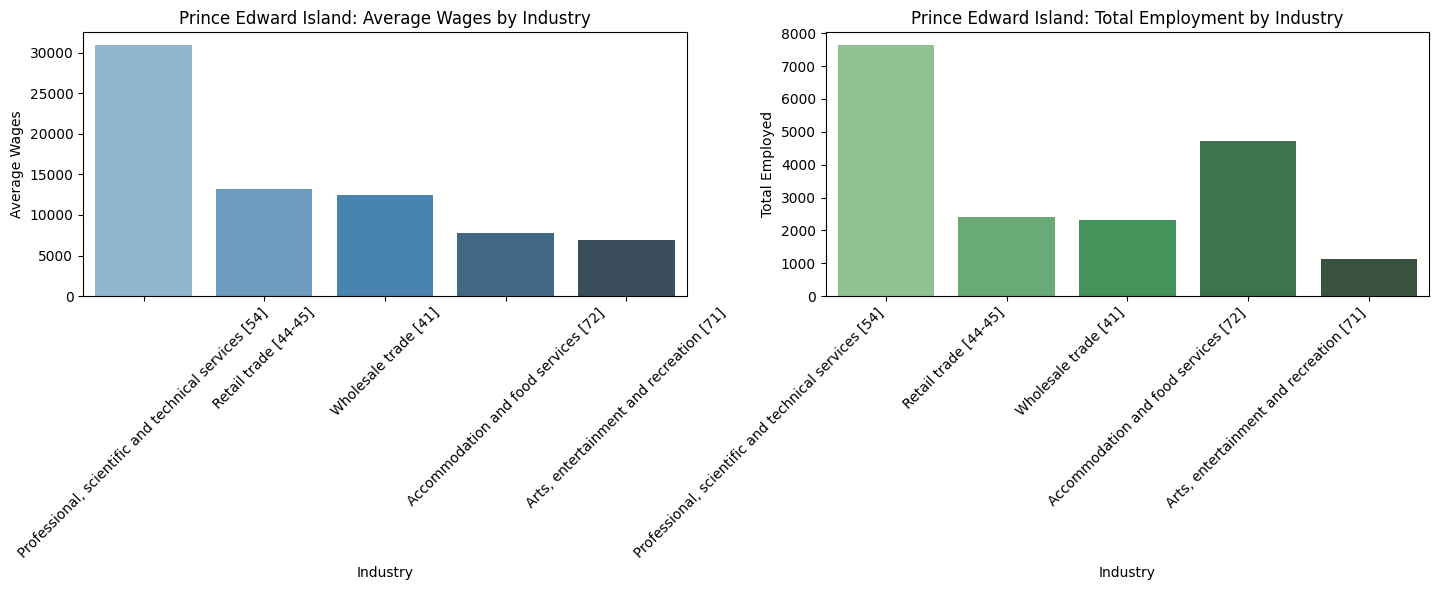

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


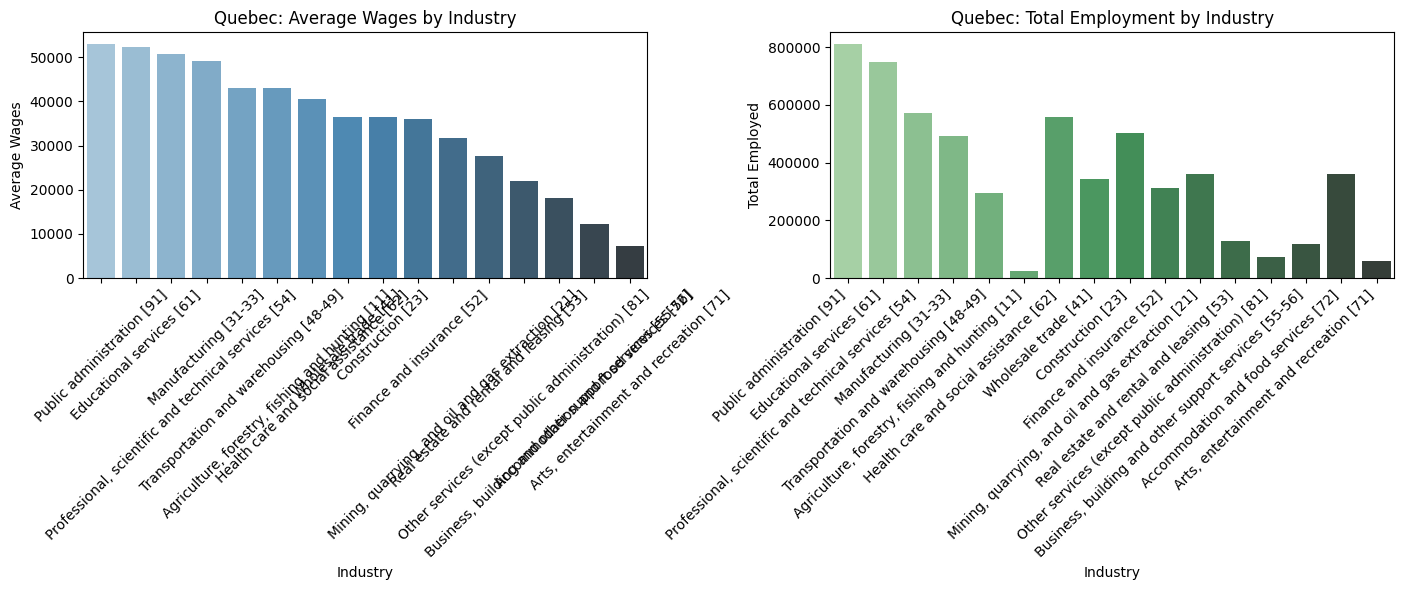

C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DHRUV PATEL\AppData\Local\Temp\ipykernel_16624\2040017292.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


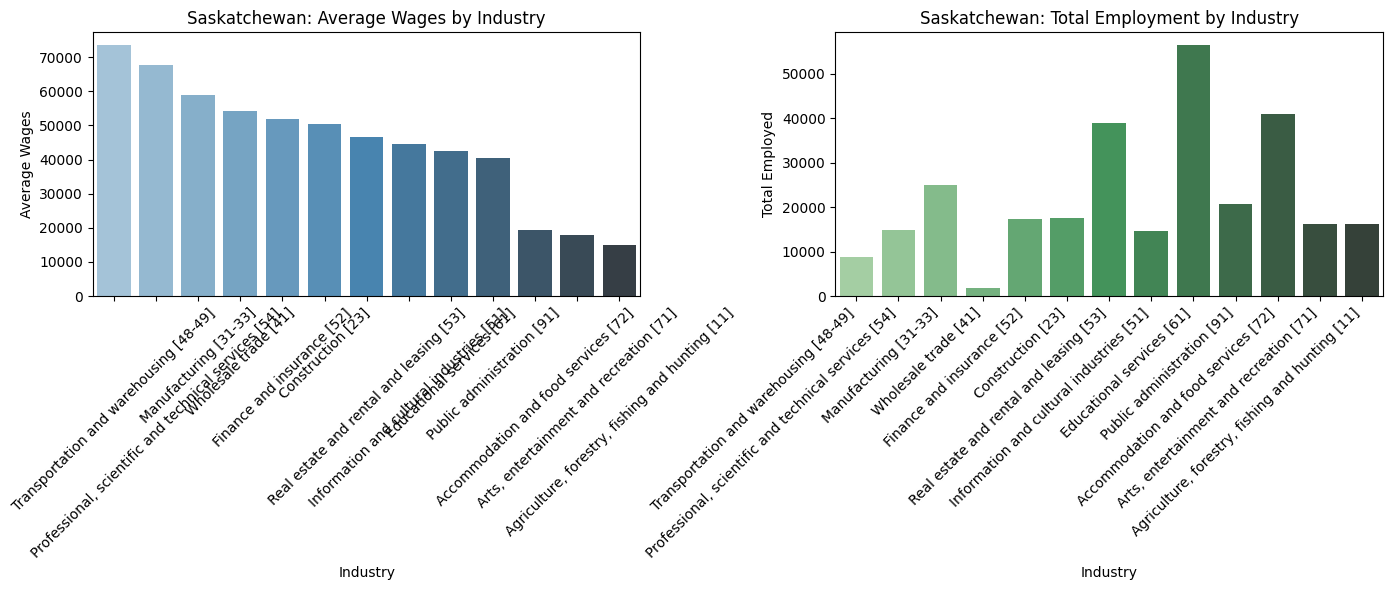

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


regions = query3_result_sql['Region'].unique()

for region in regions:
    region_data = query3_result_sql[query3_result_sql['Region'] == region]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.barplot(
        ax=axes[0],
        data=region_data,
        x='Industry',
        y='Average_Wages',
        palette='Blues_d'
    )
    axes[0].set_title(f'{region}: Average Wages by Industry')
    axes[0].set_xlabel('Industry')
    axes[0].set_ylabel('Average Wages')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.barplot(
        ax=axes[1],
        data=region_data,
        x='Industry',
        y='Total_Employed',
        palette='Greens_d'
    )
    axes[1].set_title(f'{region}: Total Employment by Industry')
    axes[1].set_xlabel('Industry')
    axes[1].set_ylabel('Total Employed')
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.show()


Findings

1. Regional Wage Variations
Different regions have distinct average wage levels across various industries. For example, British Columbia has the highest average wages in the Finance and insurance sector ($77,270), while Alberta's Utilities sector has high average wages ($72,000). In contrast, provinces like Newfoundland and Labrador and Prince Edward Island generally have lower average wages across most industries.
2. Industry-Specific Employment Numbers
The number of employed individuals varies significantly by industry and region. Ontario, for instance, has large workforces in sectors like Public administration (442,152), Educational services (1,928,049), and Health care and social assistance (1,461,614), contributing substantially to the province's economic output. Smaller provinces like Manitoba and Prince Edward Island have much smaller workforces in these sectors.
3. Economic Impact by Region and Industry
The combination of high wages and large employment numbers in specific industries can greatly impact a region's economy. For example, Ontario's strong performance in high-wage and high-employment sectors like Public administration and Educational services contributes significantly to its economic output. In contrast, regions with lower wages and smaller workforces, such as Newfoundland and Labrador and Prince Edward Island, have a different economic profile and contribute less to overall national economic output.

# Conclusion

The integration of multiple datasets has provided a comprehensive perspective on the Canadian labor market, revealing key patterns and disparities across age groups, industries, and regions. Younger workers (15–24 years) are concentrated in low-wage sectors such as retail and food services, while middle-aged workers dominate high-paying industries like utilities and professional services. Tax contributions increase progressively with age, reflecting the correlation between income levels and taxation structures. Regional analysis highlighted that provinces such as British Columbia and Alberta lead in high-wage industries like finance and utilities, whereas smaller provinces face persistent wage gaps and limited employment opportunities. These insights underscore the pressing need for targeted policies that address wage disparities, support vulnerable demographics, and mitigate regional economic imbalances.

# Summary of Project

This study explores the intricate dynamics of the Canadian labor market by leveraging diverse datasets on employment, wages, taxation, and skill shortages. Extensive data cleaning and integration efforts ensured a cohesive analytical framework that facilitated the identification of critical trends and disparities. Key findings include age-related differences in income and tax burdens, substantial regional variations in wages and employment, and the prevalence of skill shortages in specific sectors and provinces. By uncovering these patterns, the research provides actionable insights to inform policies that promote equitable economic growth and workforce inclusivity. This project emphasizes the value of data-driven approaches in addressing complex socio-economic challenges and lays a foundation for future explorations into labor market optimization.